# Imports

In [215]:
import math
import os
import sys
import pandas as pd
sys.path.append("/home/weber/PycharmProjects/EXOTIC/src")
from statannot import add_stat_annotation

pd.options.mode.chained_assignment = None  # default='warn'
import multiprocessing
import parmap
import numpy as np
import collections
from tqdm import tqdm
import pandarallel
from pandarallel import pandarallel

pandarallel.initialize(nb_workers=60, progress_bar=True)
# tqdm.pandas()
from pprint import pprint
from scipy.stats import zscore
from scipy import stats

import requests
import re
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.colors as mc
from matplotlib.colors import LogNorm
import json
import matplotlib.ticker as mtick
from utils.utils import load_config_file

## YAML FILES CONFIG
yaml = load_config_file(config_file="/home/weber/PycharmProjects/EXOTIC/src/config.yaml")
exotic_files = yaml

import matplotlib.font_manager as font_manager

font_dirs = ['/home/weber/Fonts', ]
font_files = font_manager.findSystemFonts(fontpaths=font_dirs)
font_list = font_manager.createFontList(font_files)
font_manager.fontManager.ttflist.extend(font_list)

from matplotlib import rcParams
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Arial']
rcParams['font.weight'] = 'light'

INFO: Pandarallel will run on 60 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


/home/weber/.conda/envs/ExoCarto/lib/python3.7/site-packages/ipykernel_launcher.py:42: MatplotlibDeprecationWarning: 
The createFontList function was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use FontManager.addfont instead.


In [34]:
biomart = pd.read_csv('/gstock/EXOTIC/data/OTHERS/biomart_refseq_ensembl_hgnc.txt.gz', compression='gzip', sep='\t')
biomart_strand = pd.read_csv('/gstock/EXOTIC/data/OTHERS/biomart_with_strand.txt.gz', compression='gzip', sep='\t')
biomart = pd.merge(biomart, biomart_strand[['Gene stable ID', 'Transcript stable ID', 'Strand']], on=['Gene stable ID', 'Transcript stable ID'])
biomart.head()

/home/weber/.conda/envs/ExoCarto/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3166: DtypeWarning: Columns (14) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,Gene stable ID,Gene end (bp),Gene start (bp),Gene name,Transcript start (bp),Transcript end (bp),Transcription start site (TSS),Transcript stable ID,Transcript support level (TSL),APPRIS annotation,Transcript type,Gene type,HGNC ID,RefSeq mRNA ID,Chromosome/scaffold name,Strand
0,ENSG00000198888,4262,3307,MT-ND1,3307,4262,3307,ENST00000361390,tslNA,principal1,protein_coding,protein_coding,HGNC:7455,NaN,MT,1
1,ENSG00000198763,5511,4470,MT-ND2,4470,5511,4470,ENST00000361453,tslNA,principal1,protein_coding,protein_coding,HGNC:7456,NaN,MT,1
2,ENSG00000198804,7445,5904,MT-CO1,5904,7445,5904,ENST00000361624,tslNA,principal1,protein_coding,protein_coding,HGNC:7419,NaN,MT,1
3,ENSG00000198712,8269,7586,MT-CO2,7586,8269,7586,ENST00000361739,tslNA,principal1,protein_coding,protein_coding,HGNC:7421,NaN,MT,1
4,ENSG00000228253,8572,8366,MT-ATP8,8366,8572,8366,ENST00000361851,tslNA,principal1,protein_coding,protein_coding,HGNC:7415,NaN,MT,1


In [205]:
biomart[['Gene name', 'Strand']].drop_duplicates()

,Gene name,Strand
0,MT-ND1,1
1,MT-ND2,1
2,MT-CO1,1
3,MT-CO2,1
4,MT-ATP8,1
...,...,...
340720,OR14I1,-1
340721,SH3BP5L,-1
340733,ZNF672,1
340740,ZNF692,-1


In [35]:
biomart = pd.read_csv('/gstock/EXOTIC/data/OTHERS/biomart_refseq_ensembl_hgnc.txt.gz', compression='gzip', sep='\t')
biomart_strand = pd.read_csv('/gstock/EXOTIC/data/OTHERS/biomart_with_strand.txt.gz', compression='gzip', sep='\t')
biomart = pd.merge(biomart, biomart_strand[['Gene stable ID', 'Transcript stable ID', 'Strand']], on=['Gene stable ID', 'Transcript stable ID'])
biomart.head()

,CHROM,Gene stable ID,Gene start (bp),Gene end (bp),Strand,symbol,ensg,HGNC,Exon,Ratio_num,...,Vagina,Whole Blood,EXOTIC_down,EXOTIC_bins_down,EXOTIC_tissues_down,EXOTIC_up,EXOTIC_bins_up,EXOTIC_tissues_up,Exon_start,Exon_end
0,Y,ENSG00000067646,2935281,2982506,1,ZFY,ENSG00000067646,12870,2821978-2822038,0.400000,...,NaN,0.506500,0.689761,0.65 - 0.7,[Brain - Cerebellum],0.506500,0.5 - 0.55,"[Adipose - Subcutaneous, Adipose - Visceral (O...",2821978,2822038
1,Y,ENSG00000067646,2935281,2982506,1,ZFY,ENSG00000067646,12870,2829132-2829687,0.500000,...,NaN,0.376132,0.623868,0.6 - 0.65,"[Adrenal Gland, Cervix - Ectocervix, Cervix - ...",0.789680,0.75 - 0.8,[Cells - Cultured fibroblasts],2829132,2829687
2,Y,ENSG00000067646,2935281,2982506,1,ZFY,ENSG00000067646,12870,2843201-2843285,0.100000,...,NaN,0.500000,0.713205,0.7 - 0.75,[Testis],0.500000,0.5 - 0.55,"[Adipose - Subcutaneous, Adipose - Visceral (O...",2843201,2843285
3,Y,ENSG00000067646,2935281,2982506,1,ZFY,ENSG00000067646,12870,2844711-2844863,0.500000,...,NaN,0.506250,0.696778,0.65 - 0.7,[Brain - Cerebellar Hemisphere],0.506250,0.5 - 0.55,"[Adipose - Subcutaneous, Adipose - Visceral (O...",2844711,2844863
4,Y,ENSG00000067048,12904108,12920478,1,DDX3Y,ENSG00000067048,2699,15016848-15016892,0.666667,...,0.621048,0.571262,0.582003,0.55 - 0.6,[Cervix - Ectocervix],0.621048,0.6 - 0.65,"[Cervix - Endocervix, Fallopian Tube, Ovary, U...",15016848,15016892
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24292,1,ENSG00000171163,248850006,248859144,-1,ZNF692,ENSG00000171163,26049,249151433-249151696,0.750000,...,0.500500,0.500500,0.514496,0.5 - 0.55,[Brain - Nucleus accumbens (basal ganglia)],0.616803,0.6 - 0.65,[Muscle - Skeletal],249151433,249151696
24293,1,ENSG00000171163,248850006,248859144,-1,ZNF692,ENSG00000171163,26049,249152027-249152058,0.750000,...,0.500500,0.500500,0.514496,0.5 - 0.55,[Brain - Nucleus accumbens (basal ganglia)],0.616803,0.6 - 0.65,[Muscle - Skeletal],249152027,249152058
24294,1,ENSG00000171163,248850006,248859144,-1,ZNF692,ENSG00000171163,26049,249152330-249152508,0.500000,...,0.500500,0.500500,0.514496,0.5 - 0.55,[Brain - Nucleus accumbens (basal ganglia)],0.616803,0.6 - 0.65,[Muscle - Skeletal],249152330,249152508
24295,1,ENSG00000185220,248906196,248919946,1,PGBD2,ENSG00000185220,19399,249208062-249208078,0.500000,...,0.503750,0.481508,0.698255,0.65 - 0.7,[Testis],0.516993,0.5 - 0.55,[Adipose - Visceral (Omentum)],249208062,249208078


In [208]:
exotic[['symbol', 'Strand']].drop_duplicates().Strand.value_counts()

 1    3189
-1    3088
Name: Strand, dtype: int64

In [11]:
exotic[['CHROM', 'Exon_start', 'Exon_end', 'MAP']].sort_values(by=['CHROM', 'Exon_start']).to_csv('/biolo/ngs/remap/EXOTIC_modified_zscore.bed', header=False,sep='\t', index=False)
import subprocess
subprocess.call("/usr/local/bin/perl remap_api.pl --mode asm-asm --from GCF_000001405.25 --dest GCF_000001405.26 --annotation /biolo/ngs/remap/EXOTIC_modified_zscore.bed --annot_out /biolo/ngs/remap/EXOTIC_modified_zscore_remap.bed --report_out report --in_format bed --out_format bed", shell=True)
exotic_remap_map = pd.read_csv('/biolo/ngs/remap/EXOTIC_remap.bed', sep='\t', names=['CHROM_38', 'Exon_start_38', 'Exon_end_38', 'MAP'])
exotic_remap_map = exotic_remap_map.loc[~exotic_remap_map['CHROM_38'].str.contains('HSCHR')]
exotic_remap_map

,CHROM_38,Exon_start_38,Exon_end_38,MAP
0,1,36140069,36140070,TRAPPC3_36605670-36605671
1,1,43451310,43451311,HYI_43916981-43916982
2,1,46665647,46665648,ATPAF1_47131319-47131320
3,1,69568640,69568641,LRRC7_70034323-70034324
4,1,161118177,161118178,NIT1_161087967-161087968
...,...,...,...,...
27457,Y,14622120,14622591,NLGN4Y_16734000-16734471
27458,Y,14723149,14723269,NLGN4Y_16835029-16835149
27459,Y,19723341,19723433,KDM5D_21885227-21885319
27460,Y,19741318,19741488,KDM5D_21903204-21903374


In [184]:
exotic_37_38 = pd.merge(exotic, exotic_remap_map, on='MAP')
exotic_37_38['Gene'] = exotic_37_38.MAP.apply(lambda r: r.split('_')[0])
exotic_37_38['MAP_38'] = exotic_37_38['Gene'] + '_' + exotic_37_38['Exon_start_38'].astype(str) + '-' + exotic_37_38['Exon_end_38'].astype(str)
exotic_37_38 


,CHROM,Gene stable ID,Gene start (bp),Gene end (bp),Strand,symbol,ensg,HGNC,Exon,Ratio_num,...,EXOTIC_up,EXOTIC_bins_up,EXOTIC_tissues_up,Exon_start,Exon_end,CHROM_38,Exon_start_38,Exon_end_38,Gene,MAP_38
0,Y,ENSG00000067646,2935281,2982506,1,ZFY,ENSG00000067646,12870,2821978-2822038,0.400000,...,0.506500,0.5 - 0.55,"[Adipose - Subcutaneous, Adipose - Visceral (O...",2821978,2822038,Y,2953937,2953997,ZFY,ZFY_2953937-2953997
1,Y,ENSG00000067646,2935281,2982506,1,ZFY,ENSG00000067646,12870,2829132-2829687,0.500000,...,0.789680,0.75 - 0.8,[Cells - Cultured fibroblasts],2829132,2829687,Y,2961091,2961646,ZFY,ZFY_2961091-2961646
2,Y,ENSG00000067646,2935281,2982506,1,ZFY,ENSG00000067646,12870,2843201-2843285,0.100000,...,0.500000,0.5 - 0.55,"[Adipose - Subcutaneous, Adipose - Visceral (O...",2843201,2843285,Y,2975160,2975244,ZFY,ZFY_2975160-2975244
3,Y,ENSG00000067646,2935281,2982506,1,ZFY,ENSG00000067646,12870,2844711-2844863,0.500000,...,0.506250,0.5 - 0.55,"[Adipose - Subcutaneous, Adipose - Visceral (O...",2844711,2844863,Y,2976670,2976822,ZFY,ZFY_2976670-2976822
4,Y,ENSG00000067048,12904108,12920478,1,DDX3Y,ENSG00000067048,2699,15016848-15016892,0.666667,...,0.621048,0.6 - 0.65,"[Cervix - Endocervix, Fallopian Tube, Ovary, U...",15016848,15016892,Y,12904937,12904981,DDX3Y,DDX3Y_12904937-12904981
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24263,1,ENSG00000171163,248850006,248859144,-1,ZNF692,ENSG00000171163,26049,249151433-249151696,0.750000,...,0.616803,0.6 - 0.65,[Muscle - Skeletal],249151433,249151696,1,248857234,248857497,ZNF692,ZNF692_248857234-248857497
24264,1,ENSG00000171163,248850006,248859144,-1,ZNF692,ENSG00000171163,26049,249152027-249152058,0.750000,...,0.616803,0.6 - 0.65,[Muscle - Skeletal],249152027,249152058,1,248857828,248857859,ZNF692,ZNF692_248857828-248857859
24265,1,ENSG00000171163,248850006,248859144,-1,ZNF692,ENSG00000171163,26049,249152330-249152508,0.500000,...,0.616803,0.6 - 0.65,[Muscle - Skeletal],249152330,249152508,1,248858131,248858309,ZNF692,ZNF692_248858131-248858309
24266,1,ENSG00000185220,248906196,248919946,1,PGBD2,ENSG00000185220,19399,249208062-249208078,0.500000,...,0.516993,0.5 - 0.55,[Adipose - Visceral (Omentum)],249208062,249208078,1,248913863,248913879,PGBD2,PGBD2_248913863-248913879


In [359]:
exotic_37_38['CHROM'] = exotic_37_38['CHROM'].astype(str)
exotic_37_38.to_parquet("/gstock/EXOTIC/data/EXOTIC/EXOTIC_37_38.parquet")

In [39]:
def check_exon_position(r):
    if r['Strand'] == 1:
        if r['Exon_start_38'] < r['Gene_middle'] and r['Exon_end_38'] <= r['Gene_middle']:
            return '5_prime'
        elif r['Exon_start_38'] >= r['Gene_middle'] and r['Exon_end_38'] > r['Gene_middle']:
            return '3_prime'
        elif r['Exon_start_38'] < r['Gene_middle'] and r['Exon_end_38'] > r['Gene_middle']:
            return 'middle'
    elif r['Strand'] == -1:
        if r['Exon_start_38'] < r['Gene_middle'] and r['Exon_end_38'] <= r['Gene_middle']:
            return '3_prime'
        elif r['Exon_start_38'] >= r['Gene_middle'] and r['Exon_end_38'] > r['Gene_middle']:
            return '5_prime'
        elif r['Exon_start_38'] < r['Gene_middle'] and r['Exon_end_38'] > r['Gene_middle']:
            return 'middle'
        
tqdm.pandas()
exotic_37_38['Gene_middle'] = exotic_37_38['Gene start (bp)'] + ((exotic_37_38['Gene end (bp)'] - exotic_37_38['Gene start (bp)']) / 2)
exotic_37_38['Gene_middle'] = exotic_37_38['Gene_middle'].round(0).astype(int)
exotic_37_38['Exon_bin'] = exotic_37_38.progress_apply(lambda r: check_exon_position(r), axis=1)
exotic_37_38

/home/weber/.conda/envs/ExoCarto/lib/python3.7/site-packages/tqdm/std.py:668: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel
100%|██████████| 24268/24268 [00:03<00:00, 7371.84it/s]


,CHROM,MAP,Exon_start_38,Exon_end_38,Gene start (bp),Gene end (bp),Strand,Gene,MAP_38,Gene_middle,Exon_bin
0,Y,ZFY_2821978-2822038,2953937,2953997,2935281,2982506,1,ZFY,ZFY_2953937-2953997,2958894,5_prime
1,Y,ZFY_2829132-2829687,2961091,2961646,2935281,2982506,1,ZFY,ZFY_2961091-2961646,2958894,3_prime
2,Y,ZFY_2843201-2843285,2975160,2975244,2935281,2982506,1,ZFY,ZFY_2975160-2975244,2958894,3_prime
3,Y,ZFY_2844711-2844863,2976670,2976822,2935281,2982506,1,ZFY,ZFY_2976670-2976822,2958894,3_prime
4,Y,DDX3Y_15016848-15016892,12904937,12904981,12904108,12920478,1,DDX3Y,DDX3Y_12904937-12904981,12912293,5_prime
...,...,...,...,...,...,...,...,...,...,...,...
24263,1,ZNF692_249151433-249151696,248857234,248857497,248850006,248859144,-1,ZNF692,ZNF692_248857234-248857497,248854575,5_prime
24264,1,ZNF692_249152027-249152058,248857828,248857859,248850006,248859144,-1,ZNF692,ZNF692_248857828-248857859,248854575,5_prime
24265,1,ZNF692_249152330-249152508,248858131,248858309,248850006,248859144,-1,ZNF692,ZNF692_248858131-248858309,248854575,5_prime
24266,1,PGBD2_249208062-249208078,248913863,248913879,248906196,248919946,1,PGBD2,PGBD2_248913863-248913879,248913071,3_prime


In [114]:
exotic_37_38_tmp

,CHROM,MAP,Exon_start_38,Exon_end_38,Gene start (bp),Gene end (bp),Strand,Gene,MAP_38,Gene_middle,Exon_bin,Gene_bin_size,Gene_bins
0,Y,ZFY_2821978-2822038,2953937,2953997,2935281,2982506,1,ZFY,ZFY_2953937-2953997,2958894,"[1, 0, 0, 0]",11806.25,"[2947087, 2958893, 2970700, 2982506, 2994312]"
1,Y,ZFY_2829132-2829687,2961091,2961646,2935281,2982506,1,ZFY,ZFY_2961091-2961646,2958894,"[0, 1, 0, 0]",11806.25,"[2947087, 2958893, 2970700, 2982506, 2994312]"
2,Y,ZFY_2843201-2843285,2975160,2975244,2935281,2982506,1,ZFY,ZFY_2975160-2975244,2958894,"[0, 0, 1, 0]",11806.25,"[2947087, 2958893, 2970700, 2982506, 2994312]"
3,Y,ZFY_2844711-2844863,2976670,2976822,2935281,2982506,1,ZFY,ZFY_2976670-2976822,2958894,"[0, 0, 1, 0]",11806.25,"[2947087, 2958893, 2970700, 2982506, 2994312]"
4,Y,DDX3Y_15016848-15016892,12904937,12904981,12904108,12920478,1,DDX3Y,DDX3Y_12904937-12904981,12912293,"[0, 0, 0, 0]",4092.50,"[12908200, 12912293, 12916386, 12920478, 12924..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...
24263,1,ZNF692_249151433-249151696,248857234,248857497,248850006,248859144,-1,ZNF692,ZNF692_248857234-248857497,248854575,"[0, 0, 1, 0]",2284.50,"[248852290, 248854575, 248856860, 248859144, 2..."
24264,1,ZNF692_249152027-249152058,248857828,248857859,248850006,248859144,-1,ZNF692,ZNF692_248857828-248857859,248854575,"[0, 0, 1, 0]",2284.50,"[248852290, 248854575, 248856860, 248859144, 2..."
24265,1,ZNF692_249152330-249152508,248858131,248858309,248850006,248859144,-1,ZNF692,ZNF692_248858131-248858309,248854575,"[0, 0, 1, 0]",2284.50,"[248852290, 248854575, 248856860, 248859144, 2..."
24266,1,PGBD2_249208062-249208078,248913863,248913879,248906196,248919946,1,PGBD2,PGBD2_248913863-248913879,248913071,"[0, 1, 0, 0]",3437.50,"[248909634, 248913071, 248916508, 248919946, 2..."


In [147]:

        
tqdm.pandas()

nb_bin = 10

def check_exon_position(r):
    l = [0] * nb_bin
    for j, b in enumerate(r['Gene_bins']):
        if j < nb_bin:
            if r['Exon_start_38'] >= b and r['Exon_end_38'] <= r['Gene_bins'][j+1]:
                l[j] += 1
        
#         if j < (nb_bin - 1):
#             if r['Exon_start_38'] >= b and r['Exon_end_38'] < r['Gene_bins'][j+2]:
    if l == [0] * nb_bin:
        for j, b in enumerate(r['Gene_bins']):
            if j < nb_bin:
                if r['Exon_start_38'] < b < r['Exon_end_38']:
                    l[j-1] += 1
                    l[j] += 1
#                     print(j, r['Gene_bins'][j-1], b,  r['Exon_start_38'], r['Exon_end_38'])

                
    return l

exotic_37_38_tmp = exotic_37_38.copy()

l = list()

exotic_cutoffs = [0.5,0.8,0.9]
for exotic_cutoff in exotic_cutoffs:

    exotic_37_38_tmp = exotic_37_38_tmp.loc[exotic_37_38_tmp['EXOTIC_up'] > exotic_cutoff]
#     exotic_37_38_tmp = exotic_37_38_tmp.head(3000)
    exotic_37_38_tmp['Gene_bin_size'] = (exotic_37_38_tmp['Gene end (bp)'] - exotic_37_38_tmp['Gene start (bp)']) / nb_bin
    exotic_37_38_tmp['Gene_bins'] = exotic_37_38_tmp.progress_apply(lambda r: [r['Gene start (bp)']] + [int(round((1+e)*r['Gene_bin_size'], 0)  + r['Gene start (bp)']) for e in range(nb_bin)], axis=1)
    exotic_37_38_tmp['Exon_bin'] = exotic_37_38_tmp.progress_apply(lambda r: check_exon_position(r), axis=1)
    tmp_d = {k:v for k,v in dict(collections.Counter([",".join([str(sub_e) for sub_e in e ]) for e in exotic_37_38_tmp.Exon_bin.values.tolist()])).items() if v > 10}
    tmp_d = [[v if int(e) == 1 else 0 for e in k.split(',')] for k,v in tmp_d.items()]
    tmp_df = pd.DataFrame(tmp_d)
    tmp_df.loc['Total'] = tmp_df.sum(axis=0)
    tmp_df.loc['Ratio'] = 100 * (tmp_df.loc['Total'] / tmp_df.loc['Total'].sum())
    tmp_df.columns = [str(e) for e in range(1,nb_bin +1 ,1)]
#     print(tmp_df.tail(2))
    l.append(tmp_df.tail(2))
    
concat_df_distribution =  pd.concat(l, keys=exotic_cutoffs, axis=0)
concat_df_distribution.to_excel('/gstock/EXOTIC/data/EXOTIC/EXOTIC_density_exons_{}_bins.xlsx'.format(str(nb_bin)))
concat_df_distribution

/home/weber/.conda/envs/ExoCarto/lib/python3.7/site-packages/tqdm/std.py:668: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel
100%|██████████| 497/497 [00:00<00:00, 2823.95it/s]


1            2            3            4            5  \
0.5 Total  3306.000000  2386.000000  2245.000000  2205.000000  2143.000000   
    Ratio    13.508213     9.749122     9.173000     9.009561     8.756231   
0.8 Total   222.000000   166.000000   152.000000   160.000000   123.000000   
    Ratio    15.299793    11.440386    10.475534    11.026878     8.476912   
0.9 Total    91.000000    53.000000    47.000000    63.000000    36.000000   
    Ratio    18.879668    10.995851     9.751037    13.070539     7.468880   

                     6            7            8            9           10  
0.5 Total  2079.000000  2151.000000  2269.000000  2342.000000  3348.000000  
    Ratio     8.494729     8.788919     9.271063     9.569339    13.679823  
0.8 Total   116.000000   101.000000   119.000000   123.000000   169.000000  
    Ratio     7.994487     6.960717     8.201241     8.476912    11.647140  
0.9 Total    37.000000    25.000000    37.000000    44.000000    49.000000  
    Ratio     7.676349     5.186722     7.676349     9.128631    10.165975

In [202]:

        
tqdm.pandas()

nb_bin = 10

def check_exon_position(r):
    
    l = [0] * nb_bin
    for j, b in enumerate(r['Gene_bins']):
        if j < nb_bin:
            if r['Exon_start_38'] >= b and r['Exon_end_38'] <= r['Gene_bins'][j+1]:
                l[j] += 1
        
#         if j < (nb_bin - 1):
#             if r['Exon_start_38'] >= b and r['Exon_end_38'] < r['Gene_bins'][j+2]:
    if l == [0] * nb_bin:
        for j, b in enumerate(r['Gene_bins']):
            if j < nb_bin:
                if r['Exon_start_38'] < b < r['Exon_end_38']:
                    l[j-1] += 1
                    l[j] += 1
#                     print(j, r['Gene_bins'][j-1], b,  r['Exon_start_38'], r['Exon_end_38']
    
    if r['Strand'] == -1:
        l = l[::-1]

                
    return l



min_max = 'down'

exotic_37_38_tmp = exotic_37_38.copy()
exotic_37_38_tmp = exotic_37_38_tmp[['CHROM', 'MAP', 'Exon_start_38', 'Exon_end_38', 'Gene start (bp)', 'Gene end (bp)', 'Strand', 'EXOTIC_{}'.format(min_max), 'EXOTIC_bins_{}'.format(min_max)]]
print(exotic_37_38_tmp.columns)
l = list()


exotic_cutoffs = [0.5,0.8,0.9]
for exotic_cutoff in exotic_cutoffs:

    exotic_37_38_tmp = exotic_37_38_tmp.loc[exotic_37_38_tmp['EXOTIC_{}'.format(min_max)] > exotic_cutoff]
#     exotic_37_38_tmp = exotic_37_38_tmp.head(3000)
    exotic_37_38_tmp['Gene_bin_size'] = (exotic_37_38_tmp['Gene end (bp)'] - exotic_37_38_tmp['Gene start (bp)']) / nb_bin
    exotic_37_38_tmp['Gene_bins'] = exotic_37_38_tmp.progress_apply(lambda r: [r['Gene start (bp)']] + [int(round((1+e)*r['Gene_bin_size'], 0)  + r['Gene start (bp)']) for e in range(nb_bin)], axis=1)
    exotic_37_38_tmp['Exon_bin'] = exotic_37_38_tmp.progress_apply(lambda r: check_exon_position(r), axis=1)
    tmp_d = {k:v for k,v in dict(collections.Counter([",".join([str(sub_e) for sub_e in e ]) for e in exotic_37_38_tmp.Exon_bin.values.tolist()])).items() if v > 10}
    tmp_d = [[v if int(e) == 1 else 0 for e in k.split(',')] for k,v in tmp_d.items()]
    tmp_df = pd.DataFrame(tmp_d)
    tmp_df.loc['Total'] = tmp_df.sum(axis=0)
    tmp_df.loc['Ratio'] = 100 * (tmp_df.loc['Total'] / tmp_df.loc['Total'].sum())
    tmp_df.columns = [str(e) for e in range(1,nb_bin +1 ,1)]
#     print(tmp_df.tail(2))
    l.append(tmp_df.tail(2))
    
concat_df_distribution =  pd.concat(l, keys=exotic_cutoffs, axis=0)
concat_df_distribution.to_excel('/gstock/EXOTIC/data/EXOTIC/EXOTIC_{}_density_exons_{}_bins.xlsx'.format(min_max, str(nb_bin)))
concat_df_distribution

/home/weber/.conda/envs/ExoCarto/lib/python3.7/site-packages/tqdm/std.py:668: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel
  5%|▌         | 1279/24248 [00:00<00:01, 12789.40it/s]

Index(['CHROM', 'MAP', 'Exon_start_38', 'Exon_end_38', 'Gene start (bp)',
       'Gene end (bp)', 'Strand', 'EXOTIC_down', 'EXOTIC_bins_down'],
      dtype='object')


100%|██████████| 989/989 [00:00<00:00, 14486.20it/s]


1            2            3            4            5  \
0.5 Total  2762.000000  1599.000000  1749.000000  1901.000000  2077.000000   
    Ratio    11.015834     6.377378     6.975631     7.581861     8.283811   
0.8 Total   250.000000   109.000000   136.000000   141.000000   156.000000   
    Ratio    10.642827     4.640272     5.789698     6.002554     6.641124   
0.9 Total   116.000000    51.000000    56.000000    56.000000    65.000000   
    Ratio    12.146597     5.340314     5.863874     5.863874     6.806283   

                     6            7            8            9           10  
0.5 Total  2258.000000  2566.000000  2881.000000  3234.000000  4046.000000  
    Ratio     9.005703    10.234116    11.490448    12.898337    16.136880  
0.8 Total   192.000000   268.000000   295.000000   340.000000   462.000000  
    Ratio     8.173691    11.409110    12.558536    14.474244    19.667944  
0.9 Total    81.000000    95.000000   103.000000   135.000000   197.000000  
    Ratio     8.481675     9.947644    10.785340    14.136126    20.628272

In [149]:
concat_df_distribution_ratios = concat_df_distribution.reset_index()
concat_df_distribution_ratios = concat_df_distribution_ratios.loc[concat_df_distribution_ratios['level_1'] == 'Ratio']
concat_df_distribution_ratios = concat_df_distribution_ratios.melt(id_vars='level_0', value_vars=[str(e) for e in range(1,nb_bin + 1,1)])
concat_df_distribution_ratios.head()

,level_0,variable,value
0,0.5,1,13.508213
1,0.8,1,15.299793
2,0.9,1,18.879668
3,0.5,2,9.749122
4,0.8,2,11.440386


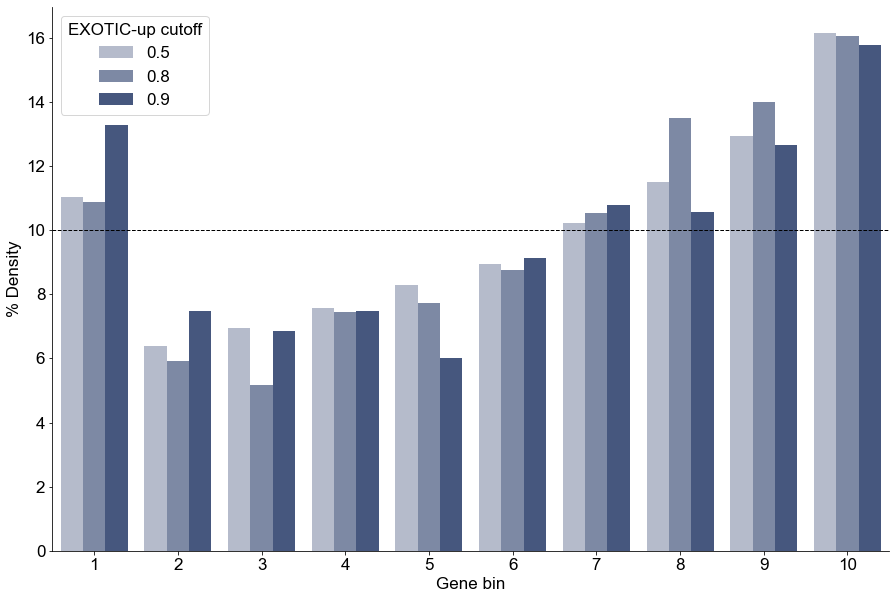

In [201]:
concat_df_distribution_ratios = concat_df_distribution.reset_index()
concat_df_distribution_ratios = concat_df_distribution_ratios.loc[concat_df_distribution_ratios['level_1'] == 'Ratio']
concat_df_distribution_ratios = concat_df_distribution_ratios.melt(id_vars='level_0', value_vars=[str(e) for e in range(1,nb_bin + 1,1)])
concat_df_distribution_ratios.head()

from colour import Color
# Color('red')
palette = ['#b1bacf', '#7687ab', '#3c5488']
plt.rcParams.update({'font.size' : 17})
f, ax = plt.subplots(figsize=(15,10))
sns.barplot(data=concat_df_distribution_ratios, x='variable', y='value', hue='level_0', palette=palette)
plt.axhline(int(round(100 / nb_bin, 0)), lw=1, ls="--", color='black')
plt.xlabel('Gene bin')
# plt.xticklabels(pl)
plt.ylabel('% Density')
ax.legend(title='EXOTIC-up cutoff')
ax.spines['top'].set_linewidth(0)
ax.spines['right'].set_linewidth(0)


   level_0 variable      value
0      0.5        1  11.015834
1      0.8        1  10.642827
2      0.9        1  12.146597
3      0.5        2   6.377378
4      0.8        2   4.640272


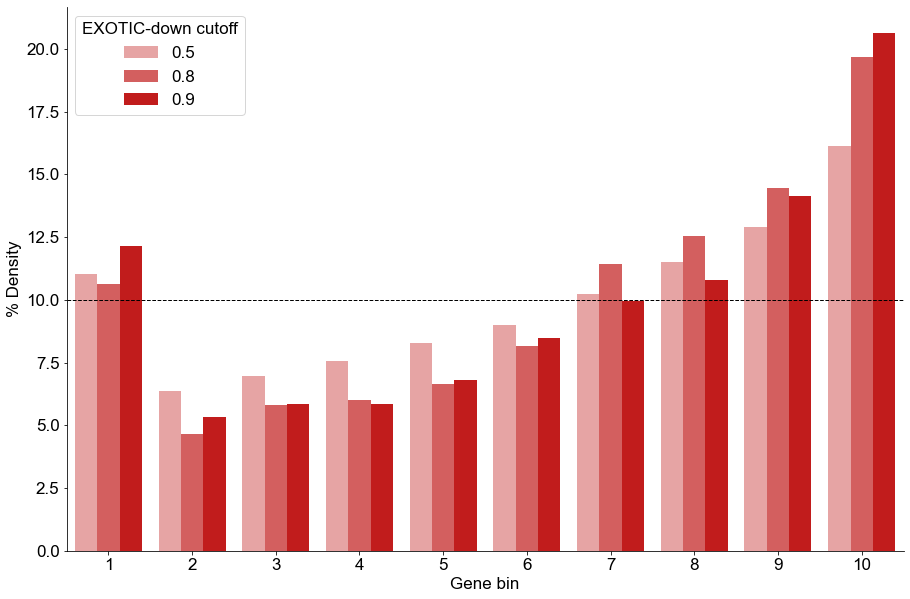

In [203]:
concat_df_distribution_ratios = concat_df_distribution.reset_index()
concat_df_distribution_ratios = concat_df_distribution_ratios.loc[concat_df_distribution_ratios['level_1'] == 'Ratio']
concat_df_distribution_ratios = concat_df_distribution_ratios.melt(id_vars='level_0', value_vars=[str(e) for e in range(1,nb_bin + 1,1)])
print(concat_df_distribution_ratios.head())

from colour import Color
# Color('red')
palette = ['#f19999', '#e64c4c', '#dc0000',]
plt.rcParams.update({'font.size' : 17})
f, ax = plt.subplots(figsize=(15,10))
sns.barplot(data=concat_df_distribution_ratios, x='variable', y='value', hue='level_0', palette=palette)
plt.axhline(int(round(100 / nb_bin, 0)), lw=1, ls="--", color='black')
plt.xlabel('Gene bin')
# plt.xticklabels(pl)
plt.ylabel('% Density')
ax.legend(title='EXOTIC-{} cutoff'.format(min_max))
ax.spines['top'].set_linewidth(0)
ax.spines['right'].set_linewidth(0)


In [12]:
merge_exotic_sqtl = pd.read_parquet('/gstock/EXOTIC/data/QTL/sQTL_ENST_modified_zscore.parquet').reset_index(drop=True)
merge_exotic_sqtl

,symbol,ensg,HGNC,Exon,Ratio_num,mRNA_nb,mRNA_nb_total,MAP,mean_proportion,Adipose - Subcutaneous,...,F.svQTL,nb.perms.svQTL,pv.svQTL,fdr.svQTL,tr_type,ENST,Tissue,gene_id,nb.perm,pv.emp.perm
0,A2ML1,ENSG00000166535,23336,8975248-8975309,0.5,1,2,A2ML1_8975248-8975309,0.69514,0.578349,...,1.457528,10100,0.231759,0.675328,tr.second,ENST00000299698,Testis,ENSG00000166535,1000.0,0.000999
1,A2ML1,ENSG00000166535,23336,8997768-8997770,0.5,1,2,A2ML1_8997768-8997770,0.12322,0.498500,...,0.710608,10100,0.486486,0.837153,tr.second,ENST00000539547,Esophagus - Mucosa,ENSG00000166535,1000.0,0.000999
2,A2ML1,ENSG00000166535,23336,8997768-8997770,0.5,1,2,A2ML1_8997768-8997770,0.12322,0.498500,...,2.392523,10100,0.096129,0.525904,tr.second,ENST00000539547,Esophagus - Mucosa,ENSG00000166535,1000.0,0.000999
3,A2ML1,ENSG00000166535,23336,8997768-8997770,0.5,1,2,A2ML1_8997768-8997770,0.12322,0.498500,...,0.279041,10100,0.742105,0.928770,tr.second,ENST00000539547,Esophagus - Mucosa,ENSG00000166535,1000.0,0.000999
4,A2ML1,ENSG00000166535,23336,8997768-8997770,0.5,1,2,A2ML1_8997768-8997770,0.12322,0.498500,...,1.698239,10100,0.185922,0.644152,tr.second,ENST00000539547,Esophagus - Mucosa,ENSG00000166535,1000.0,0.000999
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5048975,ZXDC,ENSG00000070476,28160,126158475-126158570,0.5,1,2,ZXDC_126158475-126158570,0.20989,0.500250,...,1.098075,10100,0.332937,0.746733,tr.second,ENST00000389709,Skin - Sun Exposed (Lower leg),ENSG00000070476,1000.0,0.000999
5048976,ZXDC,ENSG00000070476,28160,126158475-126158570,0.5,1,2,ZXDC_126158475-126158570,0.20989,0.500250,...,1.098075,10100,0.332937,0.746733,tr.second,ENST00000389709,Skin - Sun Exposed (Lower leg),ENSG00000070476,1000.0,0.000999
5048977,ZXDC,ENSG00000070476,28160,126158475-126158570,0.5,1,2,ZXDC_126158475-126158570,0.20989,0.500250,...,1.098075,10100,0.332937,0.746733,tr.second,ENST00000389709,Skin - Sun Exposed (Lower leg),ENSG00000070476,1000.0,0.000999
5048978,ZXDC,ENSG00000070476,28160,126158475-126158570,0.5,1,2,ZXDC_126158475-126158570,0.20989,0.500250,...,1.029523,10100,0.355311,0.760261,tr.second,ENST00000389709,Skin - Sun Exposed (Lower leg),ENSG00000070476,1000.0,0.000999


In [4]:
merge_exotic_sqtl_38 = pd.read_parquet('/gstock/EXOTIC/data/QTL/EXOTIC_sQTL_38.parquet')

In [209]:
min_max = 'up'
exotic_cutoff = 0.5
exotic_37_38_tmp = exotic_37_38.copy()
exotic_37_38_tmp = exotic_37_38_tmp.loc[exotic_37_38_tmp['EXOTIC_{}'.format(min_max)] > exotic_cutoff]
#     exotic_37_38_tmp = exotic_37_38_tmp.head(3000)
exotic_37_38_tmp['Gene_bin_size'] = (exotic_37_38_tmp['Gene end (bp)'] - exotic_37_38_tmp['Gene start (bp)']) / nb_bin
exotic_37_38_tmp['Gene_bins'] = exotic_37_38_tmp.progress_apply(lambda r: [r['Gene start (bp)']] + [int(round((1+e)*r['Gene_bin_size'], 0)  + r['Gene start (bp)']) for e in range(nb_bin)], axis=1)
exotic_37_38_tmp['Exon_bin'] = exotic_37_38_tmp.progress_apply(lambda r: check_exon_position(r), axis=1)

100%|██████████| 23671/23671 [00:01<00:00, 13958.02it/s]


In [199]:
exotic_37_38_tmp

,CHROM,Gene stable ID,Gene start (bp),Gene end (bp),Strand,symbol,ensg,HGNC,Exon,Ratio_num,...,Exon_start,Exon_end,CHROM_38,Exon_start_38,Exon_end_38,Gene,MAP_38,Gene_bin_size,Gene_bins,Exon_bin
0,Y,ENSG00000067646,2935281,2982506,1,ZFY,ENSG00000067646,12870,2821978-2822038,0.400000,...,2821978,2822038,Y,2953937,2953997,ZFY,ZFY_2953937-2953997,4722.5,"[2935281, 2940003, 2944726, 2949449, 2954171, ...","[0, 0, 0, 1, 0, 0, 0, 0, 0, 0]"
1,Y,ENSG00000067646,2935281,2982506,1,ZFY,ENSG00000067646,12870,2829132-2829687,0.500000,...,2829132,2829687,Y,2961091,2961646,ZFY,ZFY_2961091-2961646,4722.5,"[2935281, 2940003, 2944726, 2949449, 2954171, ...","[0, 0, 0, 0, 0, 1, 0, 0, 0, 0]"
2,Y,ENSG00000067646,2935281,2982506,1,ZFY,ENSG00000067646,12870,2843201-2843285,0.100000,...,2843201,2843285,Y,2975160,2975244,ZFY,ZFY_2975160-2975244,4722.5,"[2935281, 2940003, 2944726, 2949449, 2954171, ...","[0, 0, 0, 0, 0, 0, 0, 0, 1, 0]"
3,Y,ENSG00000067646,2935281,2982506,1,ZFY,ENSG00000067646,12870,2844711-2844863,0.500000,...,2844711,2844863,Y,2976670,2976822,ZFY,ZFY_2976670-2976822,4722.5,"[2935281, 2940003, 2944726, 2949449, 2954171, ...","[0, 0, 0, 0, 0, 0, 0, 0, 1, 0]"
4,Y,ENSG00000067048,12904108,12920478,1,DDX3Y,ENSG00000067048,2699,15016848-15016892,0.666667,...,15016848,15016892,Y,12904937,12904981,DDX3Y,DDX3Y_12904937-12904981,1637.0,"[12904108, 12905745, 12907382, 12909019, 12910...","[1, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24263,1,ENSG00000171163,248850006,248859144,-1,ZNF692,ENSG00000171163,26049,249151433-249151696,0.750000,...,249151433,249151696,1,248857234,248857497,ZNF692,ZNF692_248857234-248857497,913.8,"[248850006, 248850920, 248851834, 248852747, 2...","[0, 0, 0, 0, 0, 0, 0, 1, 1, 0]"
24264,1,ENSG00000171163,248850006,248859144,-1,ZNF692,ENSG00000171163,26049,249152027-249152058,0.750000,...,249152027,249152058,1,248857828,248857859,ZNF692,ZNF692_248857828-248857859,913.8,"[248850006, 248850920, 248851834, 248852747, 2...","[0, 0, 0, 0, 0, 0, 0, 0, 1, 0]"
24265,1,ENSG00000171163,248850006,248859144,-1,ZNF692,ENSG00000171163,26049,249152330-249152508,0.500000,...,249152330,249152508,1,248858131,248858309,ZNF692,ZNF692_248858131-248858309,913.8,"[248850006, 248850920, 248851834, 248852747, 2...","[0, 0, 0, 0, 0, 0, 0, 0, 1, 1]"
24266,1,ENSG00000185220,248906196,248919946,1,PGBD2,ENSG00000185220,19399,249208062-249208078,0.500000,...,249208062,249208078,1,248913863,248913879,PGBD2,PGBD2_248913863-248913879,1375.0,"[248906196, 248907571, 248908946, 248910321, 2...","[0, 0, 0, 0, 0, 1, 0, 0, 0, 0]"


In [213]:
merge_exotic_sqtl_38

,symbol,ensg,HGNC,Exon,Ratio_num,mRNA_nb,mRNA_nb_total,MAP,mean_proportion,Adipose - Subcutaneous,...,nb.perms.svQTL,pv.svQTL,fdr.svQTL,tr_type,ENST,Tissue,gene_id,nb.perm,pv.emp.perm,MAP_38
0,A2ML1,ENSG00000166535,23336,8975248-8975309,0.5,1,2,A2ML1_8975248-8975309,0.69514,0.578349,...,10100,0.231759,0.675328,tr.second,ENST00000299698,Testis,ENSG00000166535,1000.0,0.000999,A2ML1_8822652-8822713
1,A2ML1,ENSG00000166535,23336,8975248-8975309,0.5,1,2,A2ML1_8975248-8975309,0.69514,0.578349,...,10100,0.202752,0.648511,tr.second,ENST00000299698,Testis,ENSG00000166535,1000.0,0.000999,A2ML1_8822652-8822713
2,A2ML1,ENSG00000166535,23336,8997768-8997770,0.5,1,2,A2ML1_8997768-8997770,0.12322,0.498500,...,10100,0.486486,0.837153,tr.second,ENST00000539547,Esophagus - Mucosa,ENSG00000166535,1000.0,0.000999,A2ML1_8845172-8845174
3,A2ML1,ENSG00000166535,23336,8997768-8997770,0.5,1,2,A2ML1_8997768-8997770,0.12322,0.498500,...,10100,0.096129,0.525904,tr.second,ENST00000539547,Esophagus - Mucosa,ENSG00000166535,1000.0,0.000999,A2ML1_8845172-8845174
4,A2ML1,ENSG00000166535,23336,8997768-8997770,0.5,1,2,A2ML1_8997768-8997770,0.12322,0.498500,...,10100,0.742105,0.928770,tr.second,ENST00000539547,Esophagus - Mucosa,ENSG00000166535,1000.0,0.000999,A2ML1_8845172-8845174
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5037416,ZXDC,ENSG00000070476,28160,126158475-126158570,0.5,1,2,ZXDC_126158475-126158570,0.20989,0.500250,...,10100,0.332937,0.746733,tr.second,ENST00000389709,Skin - Sun Exposed (Lower leg),ENSG00000070476,1000.0,0.000999,ZXDC_126439632-126439727
5037417,ZXDC,ENSG00000070476,28160,126158475-126158570,0.5,1,2,ZXDC_126158475-126158570,0.20989,0.500250,...,10100,0.332937,0.746733,tr.second,ENST00000389709,Skin - Sun Exposed (Lower leg),ENSG00000070476,1000.0,0.000999,ZXDC_126439632-126439727
5037418,ZXDC,ENSG00000070476,28160,126158475-126158570,0.5,1,2,ZXDC_126158475-126158570,0.20989,0.500250,...,10100,0.332937,0.746733,tr.second,ENST00000389709,Skin - Sun Exposed (Lower leg),ENSG00000070476,1000.0,0.000999,ZXDC_126439632-126439727
5037419,ZXDC,ENSG00000070476,28160,126158475-126158570,0.5,1,2,ZXDC_126158475-126158570,0.20989,0.500250,...,10100,0.332937,0.746733,tr.second,ENST00000389709,Skin - Sun Exposed (Lower leg),ENSG00000070476,1000.0,0.000999,ZXDC_126439632-126439727


In [216]:
def check_position_sqtl(r):
        
    l = [0] * nb_bin
    for j, b in enumerate(r['Gene_bins']):
        if j < nb_bin:
            if b <= r['snpId_POS'] < r['Gene_bins'][j+1]:
                l[j] += 1
    if r['Strand'] == -1:
        l = l[::-1]
    return l 

sqtl_deduplicated = merge_exotic_sqtl_38[['ensg', 'symbol', 'MAP_38', 'snpId', 'Tissue']].drop_duplicates()
sqtl_deduplicated['snpId_POS'] = sqtl_deduplicated['snpId'].apply(lambda r: int(r.split('_')[1]))
sqtl_deduplicated = pd.merge(sqtl_deduplicated, exotic_37_38_tmp[['Gene_bins', 'Exon_bin', 'MAP_38', 'Strand', 'EXOTIC_up', 'EXOTIC_down', 'EXOTIC_tissues_up', 'EXOTIC_tissues_down']], on='MAP_38')
sqtl_deduplicated['snpId_bin'] = sqtl_deduplicated.parallel_apply(check_position_sqtl, axis=1)
sqtl_deduplicated

,ensg,symbol,MAP_38,snpId,Tissue,snpId_POS,Gene_bins,Exon_bin,Strand,EXOTIC_up,EXOTIC_down,EXOTIC_tissues_up,EXOTIC_tissues_down,snpId_bin
0,ENSG00000166535,A2ML1,A2ML1_8822652-8822713,12_8828564_C_G_b38,Testis,8828564,"[8822621, 8829059, 8835497, 8841935, 8848373, ...","[1, 0, 0, 0, 0, 0, 0, 0, 0, 0]",1,0.578349,0.713205,"[Adipose - Subcutaneous, Adipose - Visceral (O...",[Brain - Cerebellar Hemisphere],"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
1,ENSG00000166535,A2ML1,A2ML1_8822652-8822713,12_8831184_C_A_b38,Testis,8831184,"[8822621, 8829059, 8835497, 8841935, 8848373, ...","[1, 0, 0, 0, 0, 0, 0, 0, 0, 0]",1,0.578349,0.713205,"[Adipose - Subcutaneous, Adipose - Visceral (O...",[Brain - Cerebellar Hemisphere],"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0]"
2,ENSG00000166535,A2ML1,A2ML1_8845172-8845174,12_8858373_A_G_b38,Esophagus - Mucosa,8858373,"[8822621, 8829059, 8835497, 8841935, 8848373, ...","[0, 0, 0, 1, 0, 0, 0, 0, 0, 0]",1,0.811991,0.505000,[Uterus],[Minor Salivary Gland],"[0, 0, 0, 0, 0, 1, 0, 0, 0, 0]"
3,ENSG00000166535,A2ML1,A2ML1_8845172-8845174,12_8866835_C_T_b38,Esophagus - Mucosa,8866835,"[8822621, 8829059, 8835497, 8841935, 8848373, ...","[0, 0, 0, 1, 0, 0, 0, 0, 0, 0]",1,0.811991,0.505000,[Uterus],[Minor Salivary Gland],"[0, 0, 0, 0, 0, 0, 1, 0, 0, 0]"
4,ENSG00000166535,A2ML1,A2ML1_8845172-8845174,12_8857224_G_A_b38,Esophagus - Mucosa,8857224,"[8822621, 8829059, 8835497, 8841935, 8848373, ...","[0, 0, 0, 1, 0, 0, 0, 0, 0, 0]",1,0.811991,0.505000,[Uterus],[Minor Salivary Gland],"[0, 0, 0, 0, 0, 1, 0, 0, 0, 0]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2679654,ENSG00000070476,ZXDC,ZXDC_126439632-126439727,3_126464703_G_A_b38,Skin - Sun Exposed (Lower leg),126464703,"[126437601, 126441430, 126445259, 126449088, 1...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 1]",-1,0.574443,0.542398,[Muscle - Skeletal],[Brain - Nucleus accumbens (basal ganglia)],"[0, 0, 1, 0, 0, 0, 0, 0, 0, 0]"
2679655,ENSG00000070476,ZXDC,ZXDC_126439632-126439727,3_126466665_A_C_b38,Skin - Sun Exposed (Lower leg),126466665,"[126437601, 126441430, 126445259, 126449088, 1...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 1]",-1,0.574443,0.542398,[Muscle - Skeletal],[Brain - Nucleus accumbens (basal ganglia)],"[0, 0, 1, 0, 0, 0, 0, 0, 0, 0]"
2679656,ENSG00000070476,ZXDC,ZXDC_126439632-126439727,3_126473616_A_G_b38,Skin - Sun Exposed (Lower leg),126473616,"[126437601, 126441430, 126445259, 126449088, 1...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 1]",-1,0.574443,0.542398,[Muscle - Skeletal],[Brain - Nucleus accumbens (basal ganglia)],"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
2679657,ENSG00000070476,ZXDC,ZXDC_126439632-126439727,3_126474053_G_A_b38,Skin - Sun Exposed (Lower leg),126474053,"[126437601, 126441430, 126445259, 126449088, 1...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 1]",-1,0.574443,0.542398,[Muscle - Skeletal],[Brain - Nucleus accumbens (basal ganglia)],"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0]"


In [219]:
sqtl_deduplicated[['snpId', 'snpId_bin']].drop_duplicates(subset=['snpId'])

,snpId,snpId_bin
0,12_8828564_C_G_b38,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
1,12_8831184_C_A_b38,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0]"
2,12_8858373_A_G_b38,"[0, 0, 0, 0, 0, 1, 0, 0, 0, 0]"
3,12_8866835_C_T_b38,"[0, 0, 0, 0, 0, 0, 1, 0, 0, 0]"
4,12_8857224_G_A_b38,"[0, 0, 0, 0, 0, 1, 0, 0, 0, 0]"
...,...,...
2679519,3_126475233_T_C_b38,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
2679520,3_126477161_C_G_b38,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
2679521,3_126441758_C_T_b38,"[0, 0, 0, 0, 0, 0, 0, 0, 1, 0]"
2679522,3_126440527_G_A_b38,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 1]"


In [232]:
tmp_d = {k:v for k,v in dict(collections.Counter([",".join([str(sub_e) for sub_e in e ]) for e in sqtl_deduplicated[['snpId', 'snpId_bin']].drop_duplicates(subset=['snpId']).snpId_bin.values.tolist()])).items() if v > 10}
tmp_d = [[v if int(e) == 1 else 0 for e in k.split(',')] for k,v in tmp_d.items()]
tmp_df = pd.DataFrame(tmp_d)
tmp_df.loc['Total'] = tmp_df.sum(axis=0)
tmp_df.loc['Ratio'] = 100 * (tmp_df.loc['Total'] / tmp_df.loc['Total'].sum())
tmp_df.columns = [str(e) for e in range(1,nb_bin +1 ,1)]
concat_df_distribution = tmp_df.tail(2)
tmp_df

,1,2,3,4,5,6,7,8,9,10
0,9215.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.000000,9923.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.000000,0.000000,0.00000,0.000000,0.000000,10811.000000,0.000000,0.000000,0.000000,0.000000
3,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,10923.000000,0.000000,0.000000,0.000000
4,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,10739.000000,0.000000
5,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,10959.000000,0.000000,0.000000
6,0.000000,0.000000,10168.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
7,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,11455.000000
8,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
9,0.000000,0.000000,0.00000,0.000000,10756.000000,0.000000,0.000000,0.000000,0.000000,0.000000


   index variable      value
0  Ratio        1   8.728557
1  Ratio        2   9.399184
2  Ratio        3   9.631250
3  Ratio        4  10.063179
4  Ratio        5  10.188211
5  Ratio        6  10.240308
6  Ratio        7  10.346395
7  Ratio        8  10.380495
8  Ratio        9  10.172108
9  Ratio       10  10.850312


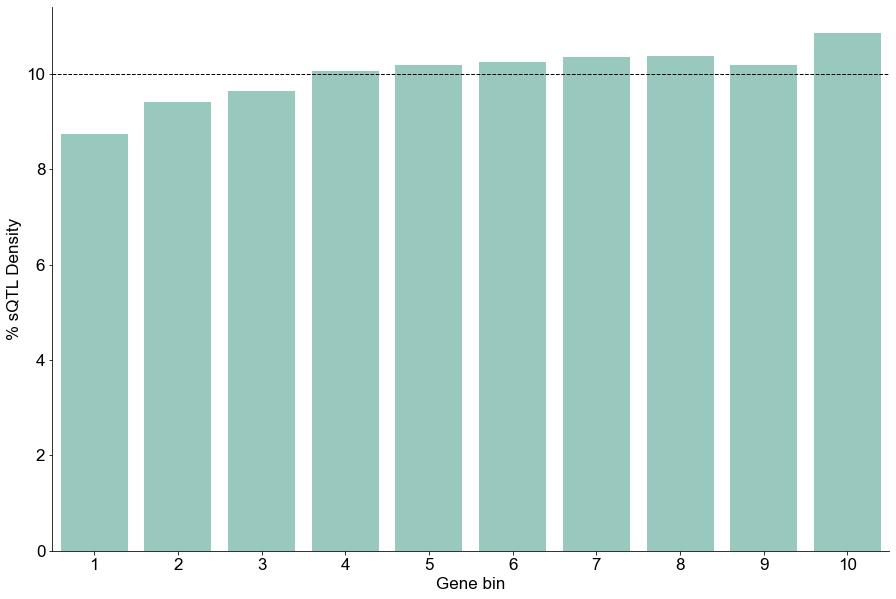

In [245]:
tmp_d = {k:v for k,v in dict(collections.Counter([",".join([str(sub_e) for sub_e in e ]) for e in sqtl_deduplicated[['snpId', 'snpId_bin']].drop_duplicates(subset=['snpId']).snpId_bin.values.tolist()])).items() if v > 10}
tmp_d = [[v if int(e) == 1 else 0 for e in k.split(',')] for k,v in tmp_d.items()]
tmp_df = pd.DataFrame(tmp_d)
tmp_df.loc['Total'] = tmp_df.sum(axis=0)
tmp_df.loc['Ratio'] = 100 * (tmp_df.loc['Total'] / tmp_df.loc['Total'].sum())
tmp_df.columns = [str(e) for e in range(1,nb_bin +1 ,1)]
concat_df_distribution = tmp_df.tail(2)
tmp_df

concat_df_distribution_ratios = concat_df_distribution.reset_index()
concat_df_distribution_ratios = concat_df_distribution_ratios.loc[concat_df_distribution_ratios['index'] == 'Ratio']
concat_df_distribution_ratios = concat_df_distribution_ratios.melt(id_vars='index', value_vars=[str(e) for e in range(1,nb_bin + 1,1)])
concat_df_distribution_ratios.head()

print(concat_df_distribution_ratios)

from colour import Color
# Color('red')
palette = ['#b1bacf', '#7687ab', '#3c5488']
plt.rcParams.update({'font.size' : 17})
f, ax = plt.subplots(figsize=(15,10))
sns.barplot(data=concat_df_distribution_ratios, x='variable', y='value', hue='index', palette=['#91D1C2'])
plt.axhline(int(round(100 / nb_bin, 0)), lw=1, ls="--", color='black')
plt.xlabel('Gene bin')
# plt.xticklabels(pl)
plt.ylabel('% sQTL Density')
ax.legend().remove()
ax.spines['top'].set_linewidth(0)
ax.spines['right'].set_linewidth(0)


In [249]:
sqtl_deduplicated_up = sqtl_deduplicated.loc[sqtl_deduplicated['EXOTIC_up'] > 0.8].explode('EXOTIC_tissues_up')
sqtl_deduplicated_up.loc[sqtl_deduplicated_up['Tissue'] == sqtl_deduplicated_up['EXOTIC_tissues_up'], 'Match_tissue'] = True
sqtl_deduplicated_up.loc[sqtl_deduplicated_up['Tissue'] != sqtl_deduplicated_up['EXOTIC_tissues_up'], 'Match_tissue'] = False
sqtl_deduplicated_up.head()

,ensg,symbol,MAP_38,snpId,Tissue,snpId_POS,Gene_bins,Exon_bin,Strand,EXOTIC_up,EXOTIC_down,EXOTIC_tissues_up,EXOTIC_tissues_down,snpId_bin,Match_tissue
2,ENSG00000166535,A2ML1,A2ML1_8845172-8845174,12_8858373_A_G_b38,Esophagus - Mucosa,8858373,"[8822621, 8829059, 8835497, 8841935, 8848373, ...","[0, 0, 0, 1, 0, 0, 0, 0, 0, 0]",1,0.811991,0.505,Uterus,[Minor Salivary Gland],"[0, 0, 0, 0, 0, 1, 0, 0, 0, 0]",False
3,ENSG00000166535,A2ML1,A2ML1_8845172-8845174,12_8866835_C_T_b38,Esophagus - Mucosa,8866835,"[8822621, 8829059, 8835497, 8841935, 8848373, ...","[0, 0, 0, 1, 0, 0, 0, 0, 0, 0]",1,0.811991,0.505,Uterus,[Minor Salivary Gland],"[0, 0, 0, 0, 0, 0, 1, 0, 0, 0]",False
4,ENSG00000166535,A2ML1,A2ML1_8845172-8845174,12_8857224_G_A_b38,Esophagus - Mucosa,8857224,"[8822621, 8829059, 8835497, 8841935, 8848373, ...","[0, 0, 0, 1, 0, 0, 0, 0, 0, 0]",1,0.811991,0.505,Uterus,[Minor Salivary Gland],"[0, 0, 0, 0, 0, 1, 0, 0, 0, 0]",False
5,ENSG00000166535,A2ML1,A2ML1_8845172-8845174,12_8862121_T_C_b38,Esophagus - Mucosa,8862121,"[8822621, 8829059, 8835497, 8841935, 8848373, ...","[0, 0, 0, 1, 0, 0, 0, 0, 0, 0]",1,0.811991,0.505,Uterus,[Minor Salivary Gland],"[0, 0, 0, 0, 0, 0, 1, 0, 0, 0]",False
6,ENSG00000166535,A2ML1,A2ML1_8845172-8845174,12_8863183_C_G_b38,Esophagus - Mucosa,8863183,"[8822621, 8829059, 8835497, 8841935, 8848373, ...","[0, 0, 0, 1, 0, 0, 0, 0, 0, 0]",1,0.811991,0.505,Uterus,[Minor Salivary Gland],"[0, 0, 0, 0, 0, 0, 1, 0, 0, 0]",False


Text(0.5, 1.0, 'EXOTIC-up cutoff = 0.8')

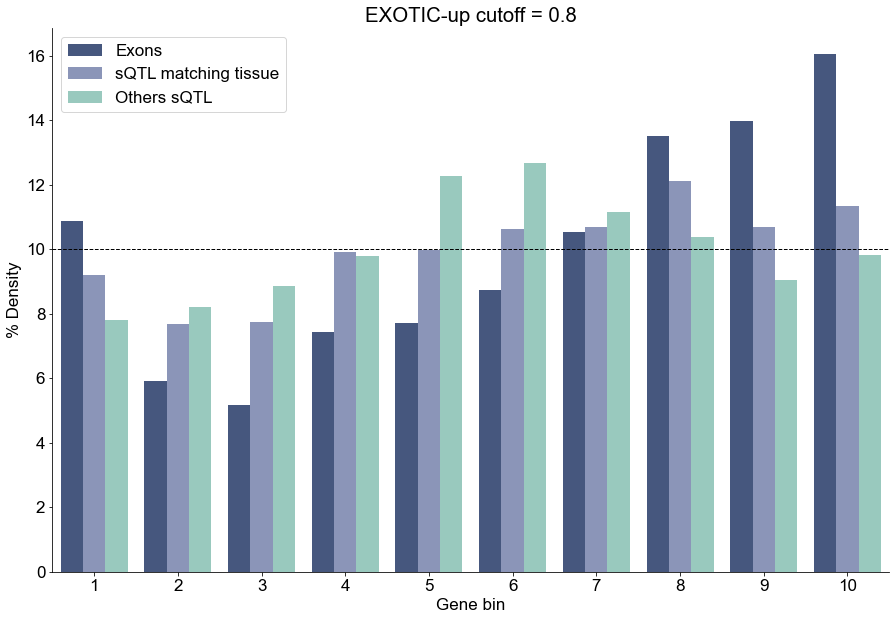

In [346]:
min_max = 'up'
nb_bin = 10
exotic_cutoff = 0.8

exons = pd.read_excel('/gstock/EXOTIC/data/EXOTIC/EXOTIC_{}_density_exons_{}_bins.xlsx'.format(min_max, str(nb_bin)))
exons.columns = ['EXOTIC_cutoff', 'Total/Ratio'] + [str(e) for e in range(1,nb_bin +1, 1)]
exons['Type'] = 'Exons'
sqtl_match = pd.read_excel('/gstock/EXOTIC/data/EXOTIC/sQTL_EXOTIC_{}_matching_tissue_density_exons_{}_bins.xlsx'.format(min_max, str(nb_bin)))
sqtl_match.columns = ['EXOTIC_cutoff', 'Total/Ratio'] + [str(e) for e in range(1,nb_bin +1, 1)]
sqtl_match['Type'] = 'sQTL matching tissue'
sqtl_others = pd.read_excel('/gstock/EXOTIC/data/EXOTIC/sQTL_EXOTIC_Not_matching_tissue_{}_density_exons_{}_bins.xlsx'.format(min_max, str(nb_bin)))
sqtl_others.columns = ['EXOTIC_cutoff', 'Total/Ratio'] + [str(e) for e in range(1,nb_bin +1, 1)]
sqtl_others['Type'] = 'Others sQTL'
concat_figure = pd.concat([
    exons, 
    sqtl_match,
    sqtl_others
])
concat_figure = concat_figure.loc[concat_figure['Total/Ratio'] == 'Ratio']
concat_figure['EXOTIC_cutoff'] = [0.5,0.8,0.9] * 3
concat_figure = concat_figure.loc[concat_figure['EXOTIC_cutoff'] == exotic_cutoff]
concat_figure = concat_figure.melt(id_vars='Type', value_vars=[str(e) for e in range(1,nb_bin + 1,1)])

palette = ['#3C5488', '#8491BF', '#91D1C2']
plt.rcParams.update({'font.size' : 17})
f, ax = plt.subplots(figsize=(15,10))
sns.barplot(data=concat_figure, x='variable', y='value', hue='Type', palette=palette)
plt.axhline(int(round(100 / nb_bin, 0)), lw=1, ls="--", color='black')
plt.xlabel('Gene bin')
# plt.xticklabels(pl)
plt.ylabel('% Density')
ax.legend(title='')
ax.spines['top'].set_linewidth(0)
ax.spines['right'].set_linewidth(0)
plt.title('EXOTIC-{} cutoff = {}'.format(min_max, str(exotic_cutoff)))

Text(0.5, 1.0, 'EXOTIC-down cutoff = 0.8')

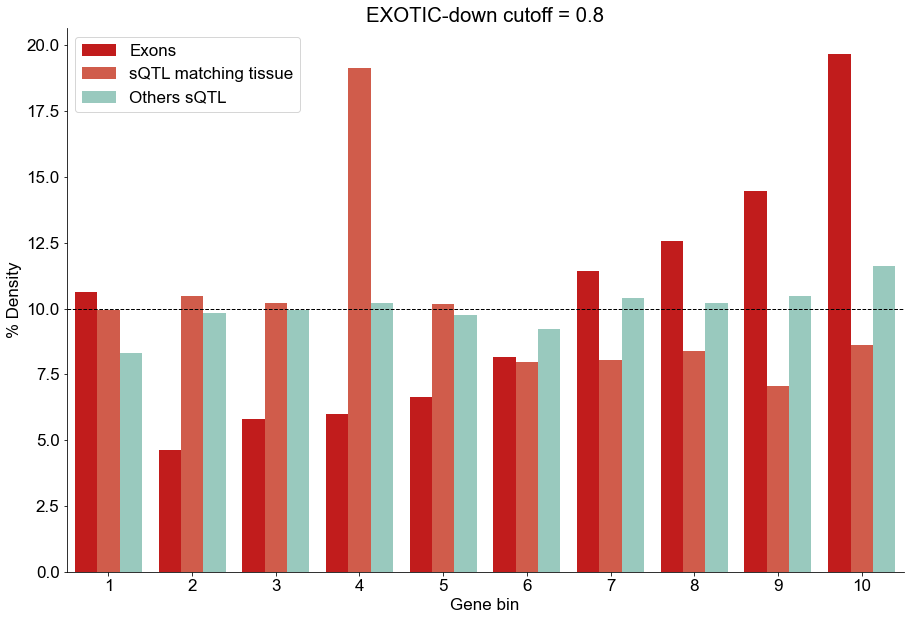

In [345]:
min_max = 'down'
nb_bin = 10
exotic_cutoff = 0.8

exons = pd.read_excel('/gstock/EXOTIC/data/EXOTIC/EXOTIC_{}_density_exons_{}_bins.xlsx'.format(min_max, str(nb_bin)))
exons.columns = ['EXOTIC_cutoff', 'Total/Ratio'] + [str(e) for e in range(1,nb_bin +1, 1)]
exons['Type'] = 'Exons'
sqtl_match = pd.read_excel('/gstock/EXOTIC/data/EXOTIC/sQTL_EXOTIC_{}_matching_tissue_density_exons_{}_bins.xlsx'.format(min_max, str(nb_bin)))
sqtl_match.columns = ['EXOTIC_cutoff', 'Total/Ratio'] + [str(e) for e in range(1,nb_bin +1, 1)]
sqtl_match['Type'] = 'sQTL matching tissue'
sqtl_others = pd.read_excel('/gstock/EXOTIC/data/EXOTIC/sQTL_EXOTIC_Not_matching_tissue_{}_density_exons_{}_bins.xlsx'.format(min_max, str(nb_bin)))
sqtl_others.columns = ['EXOTIC_cutoff', 'Total/Ratio'] + [str(e) for e in range(1,nb_bin +1, 1)]
sqtl_others['Type'] = 'Others sQTL'
concat_figure = pd.concat([
    exons, 
    sqtl_match,
    sqtl_others
])
concat_figure = concat_figure.loc[concat_figure['Total/Ratio'] == 'Ratio']
concat_figure['EXOTIC_cutoff'] = [0.5,0.8,0.9] * 3
concat_figure = concat_figure.loc[concat_figure['EXOTIC_cutoff'] == exotic_cutoff]
concat_figure = concat_figure.melt(id_vars='Type', value_vars=[str(e) for e in range(1,nb_bin + 1,1)])

palette = ['#DC0000', '#E64B35', '#91D1C2']
plt.rcParams.update({'font.size' : 17})
f, ax = plt.subplots(figsize=(15,10))
sns.barplot(data=concat_figure, x='variable', y='value', hue='Type', palette=palette)
plt.axhline(int(round(100 / nb_bin, 0)), lw=1, ls="--", color='black')
plt.xlabel('Gene bin')
# plt.xticklabels(pl)
plt.ylabel('% Density')
ax.legend(title='')
ax.spines['top'].set_linewidth(0)
ax.spines['right'].set_linewidth(0)
plt.title('EXOTIC-{} cutoff = {}'.format(min_max, str(exotic_cutoff)))

In [320]:
min_max = 'up'
nb_bin = 10
pd.read_excel('/gstock/EXOTIC/data/EXOTIC/sQTL_EXOTIC_Not_matching_tissue_{}_density_exons_{}_bins.xlsx'.format(min_max, str(nb_bin)))

,Unnamed: 0,Unnamed: 1,1,2,3,4,5,6,7,8,9,10
0,0.5,Total,9090.000000,9815.000000,10031.000000,10496.000000,10626.000000,10684.000000,10806.000000,10871.000000,10618.000000,11321.000000
1,NaN,Ratio,8.710401,9.405125,9.612104,10.057686,10.182257,10.237835,10.354740,10.417026,10.174591,10.848234
2,0.8,Total,848.000000,893.000000,962.000000,1064.000000,1333.000000,1377.000000,1211.000000,1128.000000,983.000000,1066.000000
3,NaN,Ratio,7.804878,8.219052,8.854119,9.792913,12.268753,12.673723,11.145881,10.381960,9.047400,9.811321
4,0.9,Total,277.000000,362.000000,366.000000,351.000000,430.000000,339.000000,410.000000,331.000000,290.000000,262.000000
5,NaN,Ratio,8.104154,10.590989,10.708016,10.269163,12.580456,9.918081,11.995319,9.684026,8.484494,7.665301


In [322]:
min_max = 'up'
nb_bin = 10
pd.read_excel('/gstock/EXOTIC/data/EXOTIC/sQTL_EXOTIC_{}_matching_tissue_density_exons_{}_bins.xlsx'.format(min_max, str(nb_bin)))

,Unnamed: 0,Unnamed: 1,1,2,3,4,5,6,7,8,9,10
0,0.5,Total,1704.000000,1762.000000,1699.000000,1905.000000,1763.000000,1760.000000,1907.000000,2013.000000,1782.000000,1899.000000
1,NaN,Ratio,9.365725,9.684511,9.338243,10.470485,9.690008,9.673519,10.481477,11.064087,9.794438,10.437507
2,0.8,Total,154.000000,129.000000,130.000000,166.000000,167.000000,178.000000,179.000000,203.000000,179.000000,190.000000
3,NaN,Ratio,9.194030,7.701493,7.761194,9.910448,9.970149,10.626866,10.686567,12.119403,10.686567,11.343284
4,0.9,Total,33.000000,26.000000,20.000000,28.000000,31.000000,51.000000,48.000000,46.000000,40.000000,56.000000
5,NaN,Ratio,8.707124,6.860158,5.277045,7.387863,8.179420,13.456464,12.664908,12.137203,10.554090,14.775726


100%|██████████| 3/3 [00:14<00:00,  4.74s/it]


    level_0 variable      value
0       0.5        1   9.365725
1       0.8        1   9.194030
2       0.9        1   8.707124
3       0.5        2   9.684511
4       0.8        2   7.701493
5       0.9        2   6.860158
6       0.5        3   9.338243
7       0.8        3   7.761194
8       0.9        3   5.277045
9       0.5        4  10.470485
10      0.8        4   9.910448
11      0.9        4   7.387863
12      0.5        5   9.690008
13      0.8        5   9.970149
14      0.9        5   8.179420
15      0.5        6   9.673519
16      0.8        6  10.626866
17      0.9        6  13.456464
18      0.5        7  10.481477
19      0.8        7  10.686567
20      0.9        7  12.664908
21      0.5        8  11.064087
22      0.8        8  12.119403
23      0.9        8  12.137203
24      0.5        9   9.794438
25      0.8        9  10.686567
26      0.9        9  10.554090
27      0.5       10  10.437507
28      0.8       10  11.343284
29      0.9       10  14.775726


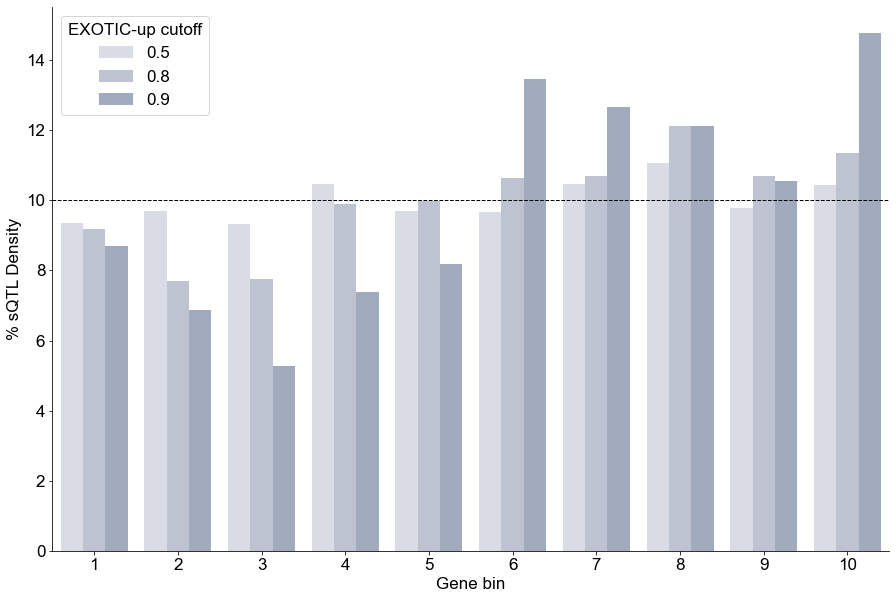

In [261]:
tmp_l = list()

exotic_cutoffs = [0.5, 0.8, 0.9]

for exotic_cutoff in tqdm(exotic_cutoffs):
    sqtl_deduplicated_up = sqtl_deduplicated.loc[sqtl_deduplicated['EXOTIC_up'] > exotic_cutoff].explode('EXOTIC_tissues_up')
    sqtl_deduplicated_up.loc[sqtl_deduplicated_up['Tissue'] == sqtl_deduplicated_up['EXOTIC_tissues_up'], 'Match_tissue'] = True
    sqtl_deduplicated_up.loc[sqtl_deduplicated_up['Tissue'] != sqtl_deduplicated_up['EXOTIC_tissues_up'], 'Match_tissue'] = False
    sqtl_deduplicated_up.head()

    tmp_d = {k:v for k,v in dict(collections.Counter([",".join([str(sub_e) for sub_e in e ]) for e in sqtl_deduplicated_up.loc[sqtl_deduplicated_up['Match_tissue'] == True][['snpId', 'snpId_bin']].drop_duplicates(subset=['snpId']).snpId_bin.values.tolist()])).items() if v > 10}
    tmp_d = [[v if int(e) == 1 else 0 for e in k.split(',')] for k,v in tmp_d.items()]
    tmp_df = pd.DataFrame(tmp_d)
    tmp_df.loc['Total'] = tmp_df.sum(axis=0)
    tmp_df.loc['Ratio'] = 100 * (tmp_df.loc['Total'] / tmp_df.loc['Total'].sum())
    tmp_df.columns = [str(e) for e in range(1,nb_bin +1 ,1)]
    tmp_l.append(tmp_df.tail(2))

concat_df_distribution =  pd.concat(tmp_l, keys=exotic_cutoffs, axis=0)
concat_df_distribution.to_excel('/gstock/EXOTIC/data/EXOTIC/sQTL_EXOTIC_{}_density_exons_{}_bins.xlsx'.format(min_max, str(nb_bin)))

concat_df_distribution_ratios = concat_df_distribution.reset_index()
concat_df_distribution_ratios = concat_df_distribution_ratios.loc[concat_df_distribution_ratios['level_1'] == 'Ratio']
concat_df_distribution_ratios = concat_df_distribution_ratios.melt(id_vars='level_0', value_vars=[str(e) for e in range(1,nb_bin + 1,1)])
concat_df_distribution_ratios.head()

print(concat_df_distribution_ratios)

from colour import Color
# Color('red')
palette = ['#b1bacf', '#7687ab', '#3c5488']
plt.rcParams.update({'font.size' : 17})
f, ax = plt.subplots(figsize=(15,10))
sns.barplot(data=concat_df_distribution_ratios, x='variable', y='value', hue='level_0', palette=palette, alpha=0.5)
plt.axhline(int(round(100 / nb_bin, 0)), lw=1, ls="--", color='black')
plt.xlabel('Gene bin')
# plt.xticklabels(pl)
plt.ylabel('% sQTL Density')
ax.legend(title='EXOTIC-{} cutoff'.format(min_max))
ax.spines['top'].set_linewidth(0)
ax.spines['right'].set_linewidth(0)


100%|██████████| 3/3 [00:09<00:00,  3.17s/it]


    level_0 variable      value
0       0.5        1   9.365725
1       0.8        1   9.194030
2       0.9        1   8.707124
3       0.5        2   9.684511
4       0.8        2   7.701493
5       0.9        2   6.860158
6       0.5        3   9.338243
7       0.8        3   7.761194
8       0.9        3   5.277045
9       0.5        4  10.470485
10      0.8        4   9.910448
11      0.9        4   7.387863
12      0.5        5   9.690008
13      0.8        5   9.970149
14      0.9        5   8.179420
15      0.5        6   9.673519
16      0.8        6  10.626866
17      0.9        6  13.456464
18      0.5        7  10.481477
19      0.8        7  10.686567
20      0.9        7  12.664908
21      0.5        8  11.064087
22      0.8        8  12.119403
23      0.9        8  12.137203
24      0.5        9   9.794438
25      0.8        9  10.686567
26      0.9        9  10.554090
27      0.5       10  10.437507
28      0.8       10  11.343284
29      0.9       10  14.775726


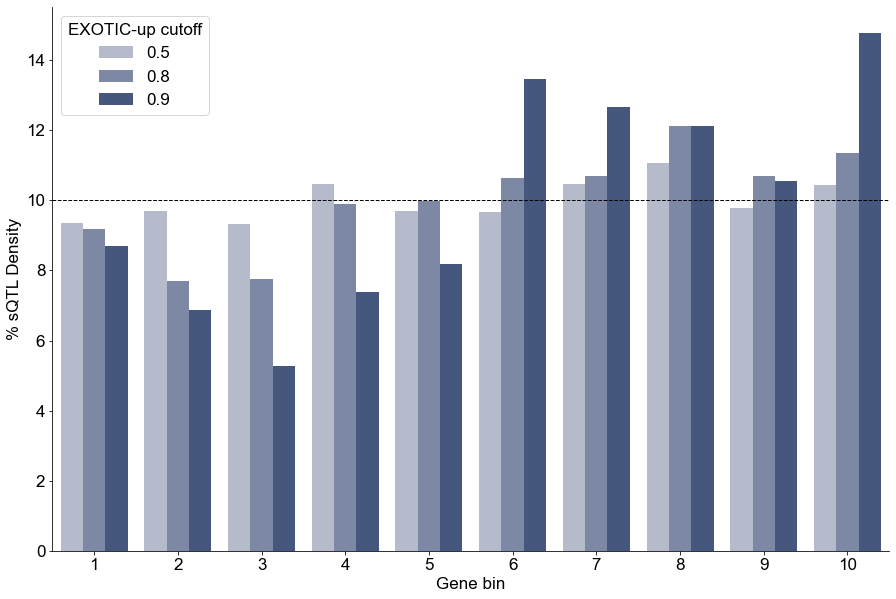

In [318]:
tmp_l = list()

exotic_cutoffs = [0.5, 0.8, 0.9]

min_max = 'up'

for exotic_cutoff in tqdm(exotic_cutoffs):
    sqtl_deduplicated_up = sqtl_deduplicated.loc[sqtl_deduplicated['EXOTIC_up'] > exotic_cutoff].explode('EXOTIC_tissues_up')
    sqtl_deduplicated_up.loc[sqtl_deduplicated_up['Tissue'] == sqtl_deduplicated_up['EXOTIC_tissues_up'], 'Match_tissue'] = True
    sqtl_deduplicated_up.loc[sqtl_deduplicated_up['Tissue'] != sqtl_deduplicated_up['EXOTIC_tissues_up'], 'Match_tissue'] = False
    sqtl_deduplicated_up.head()

    tmp_d = {k:v for k,v in dict(collections.Counter([",".join([str(sub_e) for sub_e in e ]) for e in sqtl_deduplicated_up.loc[sqtl_deduplicated_up['Match_tissue'] == True][['snpId', 'snpId_bin']].drop_duplicates(subset=['snpId']).snpId_bin.values.tolist()])).items() if v > 10}
    tmp_d = [[v if int(e) == 1 else 0 for e in k.split(',')] for k,v in tmp_d.items()]
    tmp_df = pd.DataFrame(tmp_d)
    tmp_df.loc['Total'] = tmp_df.sum(axis=0)
    tmp_df.loc['Ratio'] = 100 * (tmp_df.loc['Total'] / tmp_df.loc['Total'].sum())
    tmp_df.columns = [str(e) for e in range(1,nb_bin +1 ,1)]
    tmp_l.append(tmp_df.tail(2))

concat_df_distribution =  pd.concat(tmp_l, keys=exotic_cutoffs, axis=0)
concat_df_distribution.to_excel('/gstock/EXOTIC/data/EXOTIC/sQTL_EXOTIC_{}_matching_tissue_density_exons_{}_bins.xlsx'.format(min_max, str(nb_bin)))
concat_df_distribution_ratios = concat_df_distribution.reset_index()
concat_df_distribution_ratios = concat_df_distribution_ratios.loc[concat_df_distribution_ratios['level_1'] == 'Ratio']
concat_df_distribution_ratios = concat_df_distribution_ratios.melt(id_vars='level_0', value_vars=[str(e) for e in range(1,nb_bin + 1,1)])
concat_df_distribution_ratios.head()

print(concat_df_distribution_ratios)

from colour import Color
# Color('red')
palette = ['#b1bacf', '#7687ab', '#3c5488']
plt.rcParams.update({'font.size' : 17})
f, ax = plt.subplots(figsize=(15,10))
sns.barplot(data=concat_df_distribution_ratios, x='variable', y='value', hue='level_0', palette=palette)
plt.axhline(int(round(100 / nb_bin, 0)), lw=1, ls="--", color='black')
plt.xlabel('Gene bin')
# plt.xticklabels(pl)
plt.ylabel('% sQTL Density')
ax.legend(title='EXOTIC-{} cutoff'.format(min_max))
ax.spines['top'].set_linewidth(0)
ax.spines['right'].set_linewidth(0)


100%|██████████| 3/3 [00:08<00:00,  2.91s/it]


    level_0 variable      value
0       0.5        1   9.361702
1       0.8        1   9.953344
2       0.9        1  11.363636
3       0.5        2   9.460993
4       0.8        2  10.471747
5       0.9        2  16.528926
6       0.5        3   9.404255
7       0.8        3  10.212545
8       0.9        3  13.636364
9       0.5        4  11.446809
10      0.8        4  19.129082
11      0.9        4  12.809917
12      0.5        5  10.241135
13      0.8        5  10.160705
14      0.9        5  12.396694
15      0.5        6  10.517730
16      0.8        6   7.983411
17      0.9        6   9.504132
18      0.5        7  10.617021
19      0.8        7   8.035251
20      0.9        7   7.851240
21      0.5        8  10.382979
22      0.8        8   8.398134
23      0.9        8   5.991736
24      0.5        9   8.900709
25      0.8        9   7.050285
26      0.9        9   4.545455
27      0.5       10   9.666667
28      0.8       10   8.605495
29      0.9       10   5.371901


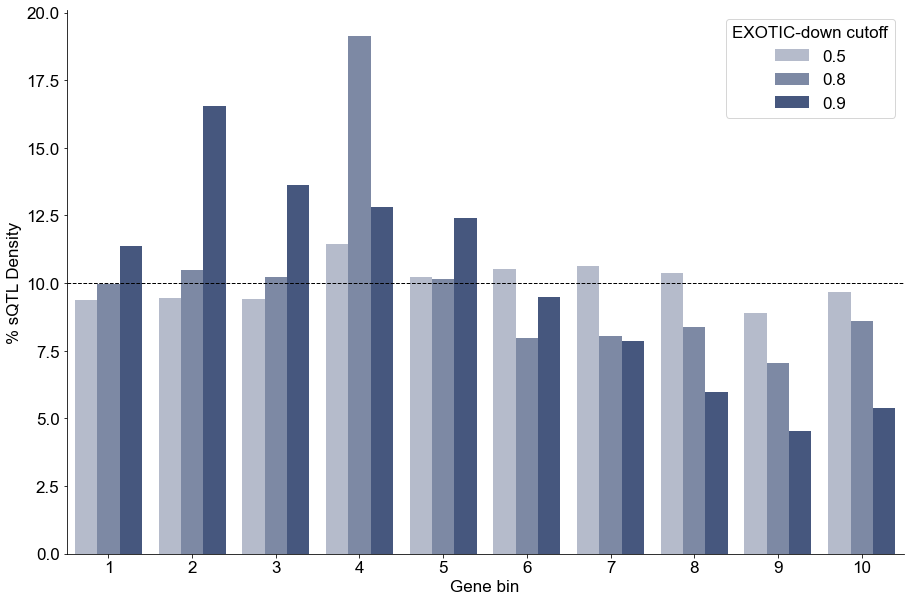

In [338]:
tmp_l = list()

exotic_cutoffs = [0.5, 0.8, 0.9]

min_max = 'down'

for exotic_cutoff in tqdm(exotic_cutoffs):
    sqtl_deduplicated_up = sqtl_deduplicated.loc[sqtl_deduplicated['EXOTIC_{}'.format(min_max)] > exotic_cutoff].explode('EXOTIC_tissues_{}'.format(min_max))
    sqtl_deduplicated_up.loc[sqtl_deduplicated_up['Tissue'] == sqtl_deduplicated_up['EXOTIC_tissues_{}'.format(min_max)], 'Match_tissue'] = True
    sqtl_deduplicated_up.loc[sqtl_deduplicated_up['Tissue'] != sqtl_deduplicated_up['EXOTIC_tissues_{}'.format(min_max)], 'Match_tissue'] = False
    sqtl_deduplicated_up.head()

    tmp_d = {k:v for k,v in dict(collections.Counter([",".join([str(sub_e) for sub_e in e ]) for e in sqtl_deduplicated_up.loc[sqtl_deduplicated_up['Match_tissue'] == True][['snpId', 'snpId_bin']].drop_duplicates(subset=['snpId']).snpId_bin.values.tolist()])).items() if v > 10}
    tmp_d = [[v if int(e) == 1 else 0 for e in k.split(',')] for k,v in tmp_d.items()]
    tmp_df = pd.DataFrame(tmp_d)
    tmp_df.loc['Total'] = tmp_df.sum(axis=0)
    tmp_df.loc['Ratio'] = 100 * (tmp_df.loc['Total'] / tmp_df.loc['Total'].sum())
    tmp_df.columns = [str(e) for e in range(1,nb_bin +1 ,1)]
    tmp_l.append(tmp_df.tail(2))

concat_df_distribution =  pd.concat(tmp_l, keys=exotic_cutoffs, axis=0)
concat_df_distribution.to_excel('/gstock/EXOTIC/data/EXOTIC/sQTL_EXOTIC_{}_matching_tissue_density_exons_{}_bins.xlsx'.format(min_max, str(nb_bin)))
concat_df_distribution_ratios = concat_df_distribution.reset_index()
concat_df_distribution_ratios = concat_df_distribution_ratios.loc[concat_df_distribution_ratios['level_1'] == 'Ratio']
concat_df_distribution_ratios = concat_df_distribution_ratios.melt(id_vars='level_0', value_vars=[str(e) for e in range(1,nb_bin + 1,1)])
concat_df_distribution_ratios.head()

print(concat_df_distribution_ratios)

from colour import Color
# Color('red')
palette = ['#b1bacf', '#7687ab', '#3c5488']
plt.rcParams.update({'font.size' : 17})
f, ax = plt.subplots(figsize=(15,10))
sns.barplot(data=concat_df_distribution_ratios, x='variable', y='value', hue='level_0', palette=palette)
plt.axhline(int(round(100 / nb_bin, 0)), lw=1, ls="--", color='black')
plt.xlabel('Gene bin')
# plt.xticklabels(pl)
plt.ylabel('% sQTL Density')
ax.legend(title='EXOTIC-{} cutoff'.format(min_max))
ax.spines['top'].set_linewidth(0)
ax.spines['right'].set_linewidth(0)


100%|██████████| 3/3 [00:10<00:00,  3.36s/it]


    level_0 variable      value
0       0.5        1   8.734013
1       0.8        1   8.330250
2       0.9        1   8.244023
3       0.5        2   9.364903
4       0.8        2   9.840917
5       0.9        2   8.615004
6       0.5        3   9.615348
7       0.8        3   9.939573
8       0.9        3  10.181369
9       0.5        4  10.031162
10      0.8        4  10.198545
11      0.9        4   9.343226
12      0.5        5  10.208959
13      0.8        5   9.742262
14      0.9        5  10.098928
15      0.5        6  10.248150
16      0.8        6   9.230485
17      0.9        6   9.604287
18      0.5        7  10.366681
19      0.8        7  10.389690
20      0.9        7  11.569112
21      0.5        8  10.373373
22      0.8        8  10.217043
23      0.9        8  10.469909
24      0.5        9  10.170723
25      0.8        9  10.488346
26      0.9        9  10.414949
27      0.5       10  10.886688
28      0.8       10  11.622888
29      0.9       10  11.459192


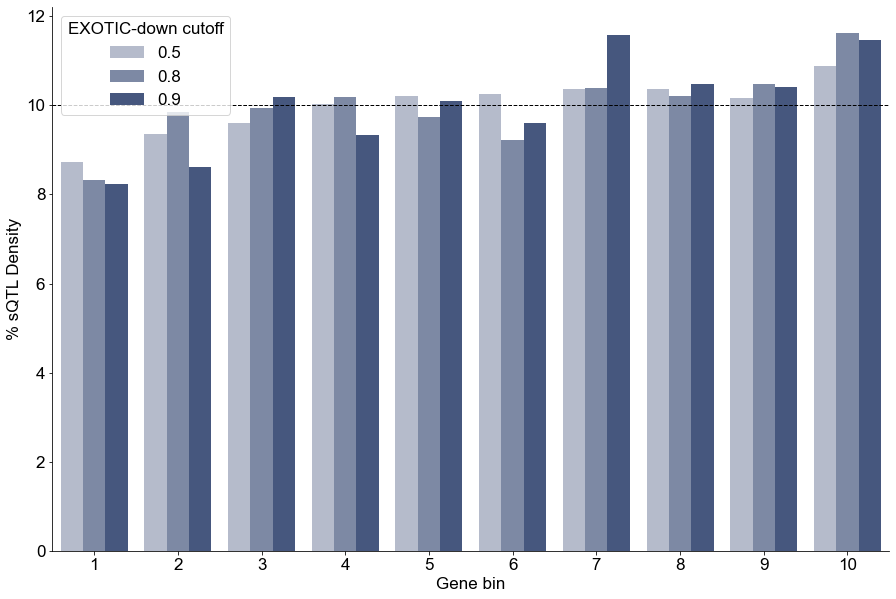

In [340]:
tmp_l = list()

min_max = 'down'

exotic_cutoffs = [0.5, 0.8, 0.9]

for exotic_cutoff in tqdm(exotic_cutoffs):
    sqtl_deduplicated_up = sqtl_deduplicated.loc[sqtl_deduplicated['EXOTIC_{}'.format(min_max)] > exotic_cutoff].explode('EXOTIC_tissues_{}'.format(min_max))
    sqtl_deduplicated_up.loc[sqtl_deduplicated_up['Tissue'] == sqtl_deduplicated_up['EXOTIC_tissues_{}'.format(min_max)], 'Match_tissue'] = True
    sqtl_deduplicated_up.loc[sqtl_deduplicated_up['Tissue'] != sqtl_deduplicated_up['EXOTIC_tissues_{}'.format(min_max)], 'Match_tissue'] = False
    sqtl_deduplicated_up.head()

    tmp_d = {k:v for k,v in dict(collections.Counter([",".join([str(sub_e) for sub_e in e ]) for e in sqtl_deduplicated_up.loc[sqtl_deduplicated_up['Match_tissue'] == False][['snpId', 'snpId_bin']].drop_duplicates(subset=['snpId']).snpId_bin.values.tolist()])).items() if v > 10}
    tmp_d = [[v if int(e) == 1 else 0 for e in k.split(',')] for k,v in tmp_d.items()]
    tmp_df = pd.DataFrame(tmp_d)
    tmp_df.loc['Total'] = tmp_df.sum(axis=0)
    tmp_df.loc['Ratio'] = 100 * (tmp_df.loc['Total'] / tmp_df.loc['Total'].sum())
    tmp_df.columns = [str(e) for e in range(1,nb_bin +1 ,1)]
    tmp_l.append(tmp_df.tail(2))

concat_df_distribution =  pd.concat(tmp_l, keys=exotic_cutoffs, axis=0)
concat_df_distribution.to_excel('/gstock/EXOTIC/data/EXOTIC/sQTL_EXOTIC_Not_matching_tissue_{}_density_exons_{}_bins.xlsx'.format(min_max, str(nb_bin)))
concat_df_distribution_ratios = concat_df_distribution.reset_index()
concat_df_distribution_ratios = concat_df_distribution_ratios.loc[concat_df_distribution_ratios['level_1'] == 'Ratio']
concat_df_distribution_ratios = concat_df_distribution_ratios.melt(id_vars='level_0', value_vars=[str(e) for e in range(1,nb_bin + 1,1)])
concat_df_distribution_ratios.head()

print(concat_df_distribution_ratios)

from colour import Color
# Color('red')
palette = ['#b1bacf', '#7687ab', '#3c5488']
plt.rcParams.update({'font.size' : 17})
f, ax = plt.subplots(figsize=(15,10))
sns.barplot(data=concat_df_distribution_ratios, x='variable', y='value', hue='level_0', palette=palette)
plt.axhline(int(round(100 / nb_bin, 0)), lw=1, ls="--", color='black')
plt.xlabel('Gene bin')
# plt.xticklabels(pl)
plt.ylabel('% sQTL Density')
ax.legend(title='EXOTIC-{} cutoff'.format(min_max))
ax.spines['top'].set_linewidth(0)
ax.spines['right'].set_linewidth(0)


100%|██████████| 3/3 [00:10<00:00,  3.42s/it]


    level_0 variable      value
0       0.5        1   8.734013
1       0.8        1   8.330250
2       0.9        1   8.244023
3       0.5        2   9.364903
4       0.8        2   9.840917
5       0.9        2   8.615004
6       0.5        3   9.615348
7       0.8        3   9.939573
8       0.9        3  10.181369
9       0.5        4  10.031162
10      0.8        4  10.198545
11      0.9        4   9.343226
12      0.5        5  10.208959
13      0.8        5   9.742262
14      0.9        5  10.098928
15      0.5        6  10.248150
16      0.8        6   9.230485
17      0.9        6   9.604287
18      0.5        7  10.366681
19      0.8        7  10.389690
20      0.9        7  11.569112
21      0.5        8  10.373373
22      0.8        8  10.217043
23      0.9        8  10.469909
24      0.5        9  10.170723
25      0.8        9  10.488346
26      0.9        9  10.414949
27      0.5       10  10.886688
28      0.8       10  11.622888
29      0.9       10  11.459192


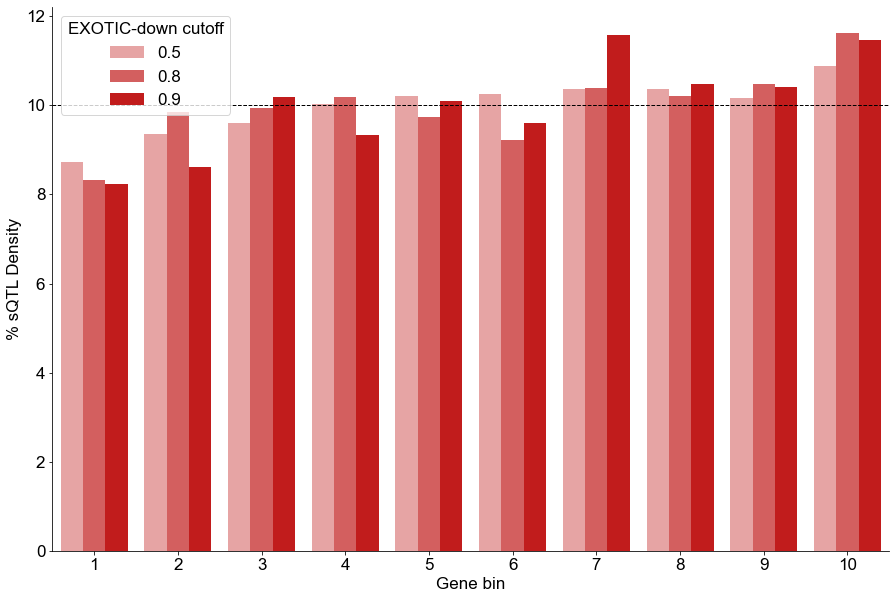

In [336]:
tmp_l = list()

min_max = 'down'

exotic_cutoffs = [0.5, 0.8, 0.9]

for exotic_cutoff in tqdm(exotic_cutoffs):
    sqtl_deduplicated_up = sqtl_deduplicated.loc[sqtl_deduplicated['EXOTIC_{}'.format(min_max)] > exotic_cutoff].explode('EXOTIC_tissues_{}'.format(min_max))
    sqtl_deduplicated_up.loc[sqtl_deduplicated_up['Tissue'] == sqtl_deduplicated_up['EXOTIC_tissues_{}'.format(min_max)], 'Match_tissue'] = True
    sqtl_deduplicated_up.loc[sqtl_deduplicated_up['Tissue'] != sqtl_deduplicated_up['EXOTIC_tissues_{}'.format(min_max)], 'Match_tissue'] = False
    sqtl_deduplicated_up.head()

    tmp_d = {k:v for k,v in dict(collections.Counter([",".join([str(sub_e) for sub_e in e ]) for e in sqtl_deduplicated_up.loc[sqtl_deduplicated_up['Match_tissue'] == False][['snpId', 'snpId_bin']].drop_duplicates(subset=['snpId']).snpId_bin.values.tolist()])).items() if v > 10}
    tmp_d = [[v if int(e) == 1 else 0 for e in k.split(',')] for k,v in tmp_d.items()]
    tmp_df = pd.DataFrame(tmp_d)
    tmp_df.loc['Total'] = tmp_df.sum(axis=0)
    tmp_df.loc['Ratio'] = 100 * (tmp_df.loc['Total'] / tmp_df.loc['Total'].sum())
    tmp_df.columns = [str(e) for e in range(1,nb_bin +1 ,1)]
    tmp_l.append(tmp_df.tail(2))

concat_df_distribution =  pd.concat(tmp_l, keys=exotic_cutoffs, axis=0)
concat_df_distribution.to_excel('/gstock/EXOTIC/data/EXOTIC/sQTL_EXOTIC_Not_matching_{}_density_exons_{}_bins.xlsx'.format(min_max, str(nb_bin)))
concat_df_distribution_ratios = concat_df_distribution.reset_index()
concat_df_distribution_ratios = concat_df_distribution_ratios.loc[concat_df_distribution_ratios['level_1'] == 'Ratio']
concat_df_distribution_ratios = concat_df_distribution_ratios.melt(id_vars='level_0', value_vars=[str(e) for e in range(1,nb_bin + 1,1)])
concat_df_distribution_ratios.head()

print(concat_df_distribution_ratios)

from colour import Color
# Color('red')
palette = ['#f19999', '#e64c4c', '#dc0000',]
plt.rcParams.update({'font.size' : 17})
f, ax = plt.subplots(figsize=(15,10))
sns.barplot(data=concat_df_distribution_ratios, x='variable', y='value', hue='level_0', palette=palette)
plt.axhline(int(round(100 / nb_bin, 0)), lw=1, ls="--", color='black')
plt.xlabel('Gene bin')
# plt.xticklabels(pl)
plt.ylabel('% sQTL Density')
ax.legend(title='EXOTIC-{} cutoff'.format(min_max))
ax.spines['top'].set_linewidth(0)
ax.spines['right'].set_linewidth(0)


In [282]:
sorted(sqtl_deduplicated.Tissue.unique())

['Adipose - Subcutaneous',
 'Adipose - Visceral (Omentum)',
 'Adrenal Gland',
 'Artery - Aorta',
 'Artery - Coronary',
 'Artery - Tibial',
 'Brain - Amygdala',
 'Brain - Anterior cingulate cortex (BA24)',
 'Brain - Caudate (basal ganglia)',
 'Brain - Cerebellar Hemisphere',
 'Brain - Cerebellum',
 'Brain - Cortex',
 'Brain - Frontal Cortex (BA9)',
 'Brain - Hippocampus',
 'Brain - Hypothalamus',
 'Brain - Nucleus accumbens (basal ganglia)',
 'Brain - Putamen (basal ganglia)',
 'Brain - Spinal cord (cervical c-1)',
 'Brain - Substantia nigra',
 'Breast - Mammary Tissue',
 'Cells - Cultured fibroblasts',
 'Cells - EBV-transformed lymphocytes',
 'Colon - Sigmoid',
 'Colon - Transverse',
 'Esophagus - Gastroesophageal Junction',
 'Esophagus - Mucosa',
 'Esophagus - Muscularis',
 'Heart - Atrial Appendage',
 'Heart - Left Ventricle',
 'Kidney - Cortex',
 'Liver',
 'Lung',
 'Minor Salivary Gland',
 'Muscle - Skeletal',
 'Nerve - Tibial',
 'Ovary',
 'Pancreas',
 'Pituitary',
 'Prostate',
 'Sk

In [298]:
tissues = sorted(sqtl_deduplicated.Tissue.unique().tolist())
print(tissues)
print(len(tissues))

['Adipose - Subcutaneous', 'Adipose - Visceral (Omentum)', 'Adrenal Gland', 'Artery - Aorta', 'Artery - Coronary', 'Artery - Tibial', 'Brain - Amygdala', 'Brain - Anterior cingulate cortex (BA24)', 'Brain - Caudate (basal ganglia)', 'Brain - Cerebellar Hemisphere', 'Brain - Cerebellum', 'Brain - Cortex', 'Brain - Frontal Cortex (BA9)', 'Brain - Hippocampus', 'Brain - Hypothalamus', 'Brain - Nucleus accumbens (basal ganglia)', 'Brain - Putamen (basal ganglia)', 'Brain - Spinal cord (cervical c-1)', 'Brain - Substantia nigra', 'Breast - Mammary Tissue', 'Cells - Cultured fibroblasts', 'Cells - EBV-transformed lymphocytes', 'Colon - Sigmoid', 'Colon - Transverse', 'Esophagus - Gastroesophageal Junction', 'Esophagus - Mucosa', 'Esophagus - Muscularis', 'Heart - Atrial Appendage', 'Heart - Left Ventricle', 'Kidney - Cortex', 'Liver', 'Lung', 'Minor Salivary Gland', 'Muscle - Skeletal', 'Nerve - Tibial', 'Ovary', 'Pancreas', 'Pituitary', 'Prostate', 'Skin - Not Sun Exposed (Suprapubic)', 'Sk

In [349]:
gtex_colors = pd.read_excel('/gstock/EXOTIC/data/OTHERS/gtex_colors.xlsx')
gtex_colors[['Tissue', 'Color']].set_index('Tissue').to_dict()['Color']

{'Adipose - Subcutaneous': '#FF6600',
 'Adipose - Visceral (Omentum)': '#FFAA00',
 'Adrenal Gland': '#33DD33',
 'Artery - Aorta': '#FF5555',
 'Artery - Coronary': '#FFAA99',
 'Artery - Tibial': '#FF0000',
 'Bladder': '#A90000',
 'Brain - Amygdala': '#EEEE00',
 'Brain - Anterior cingulate cortex (BA24)': '#EEEE00',
 'Brain - Caudate (basal ganglia)': '#EEEE00',
 'Brain - Cerebellar Hemisphere': '#EEEE00',
 'Brain - Cerebellum': '#EEEE00',
 'Brain - Cortex': '#EEEE00',
 'Brain - Frontal Cortex (BA9)': '#EEEE00',
 'Brain - Hippocampus': '#EEEE00',
 'Brain - Hypothalamus': '#EEEE00',
 'Brain - Nucleus accumbens (basal ganglia)': '#EEEE00',
 'Brain - Putamen (basal ganglia)': '#EEEE00',
 'Brain - Spinal cord (cervical c-1)': '#EEEE00',
 'Brain - Substantia nigra': '#EEEE00',
 'Breast - Mammary Tissue': '#33CCCC',
 'Cells - Cultured fibroblasts': '#AAEEFF',
 'Cells - EBV-transformed lymphocytes': '#CC66FF',
 'Cervix - Ectocervix': '#FFCCCC',
 'Cervix - Endocervix': '#CCAADD',
 'Colon - Sigmo

100%|██████████| 49/49 [00:00<00:00, 103.82it/s]


   level_0 variable       value                               Tissue
0      0.9        1   15.625000                    Muscle - Skeletal
1      0.9        2    3.125000                    Muscle - Skeletal
2      0.9        3    0.000000                    Muscle - Skeletal
3      0.9        4    0.000000                    Muscle - Skeletal
4      0.9        5    0.000000                    Muscle - Skeletal
5      0.9        6    0.000000                    Muscle - Skeletal
6      0.9        7   29.687500                    Muscle - Skeletal
7      0.9        8   10.937500                    Muscle - Skeletal
8      0.9        9    3.125000                    Muscle - Skeletal
9      0.9       10   37.500000                    Muscle - Skeletal
0      0.9        1    0.000000  Skin - Not Sun Exposed (Suprapubic)
1      0.9        2    0.000000  Skin - Not Sun Exposed (Suprapubic)
2      0.9        3    0.000000  Skin - Not Sun Exposed (Suprapubic)
3      0.9        4    0.000000  S

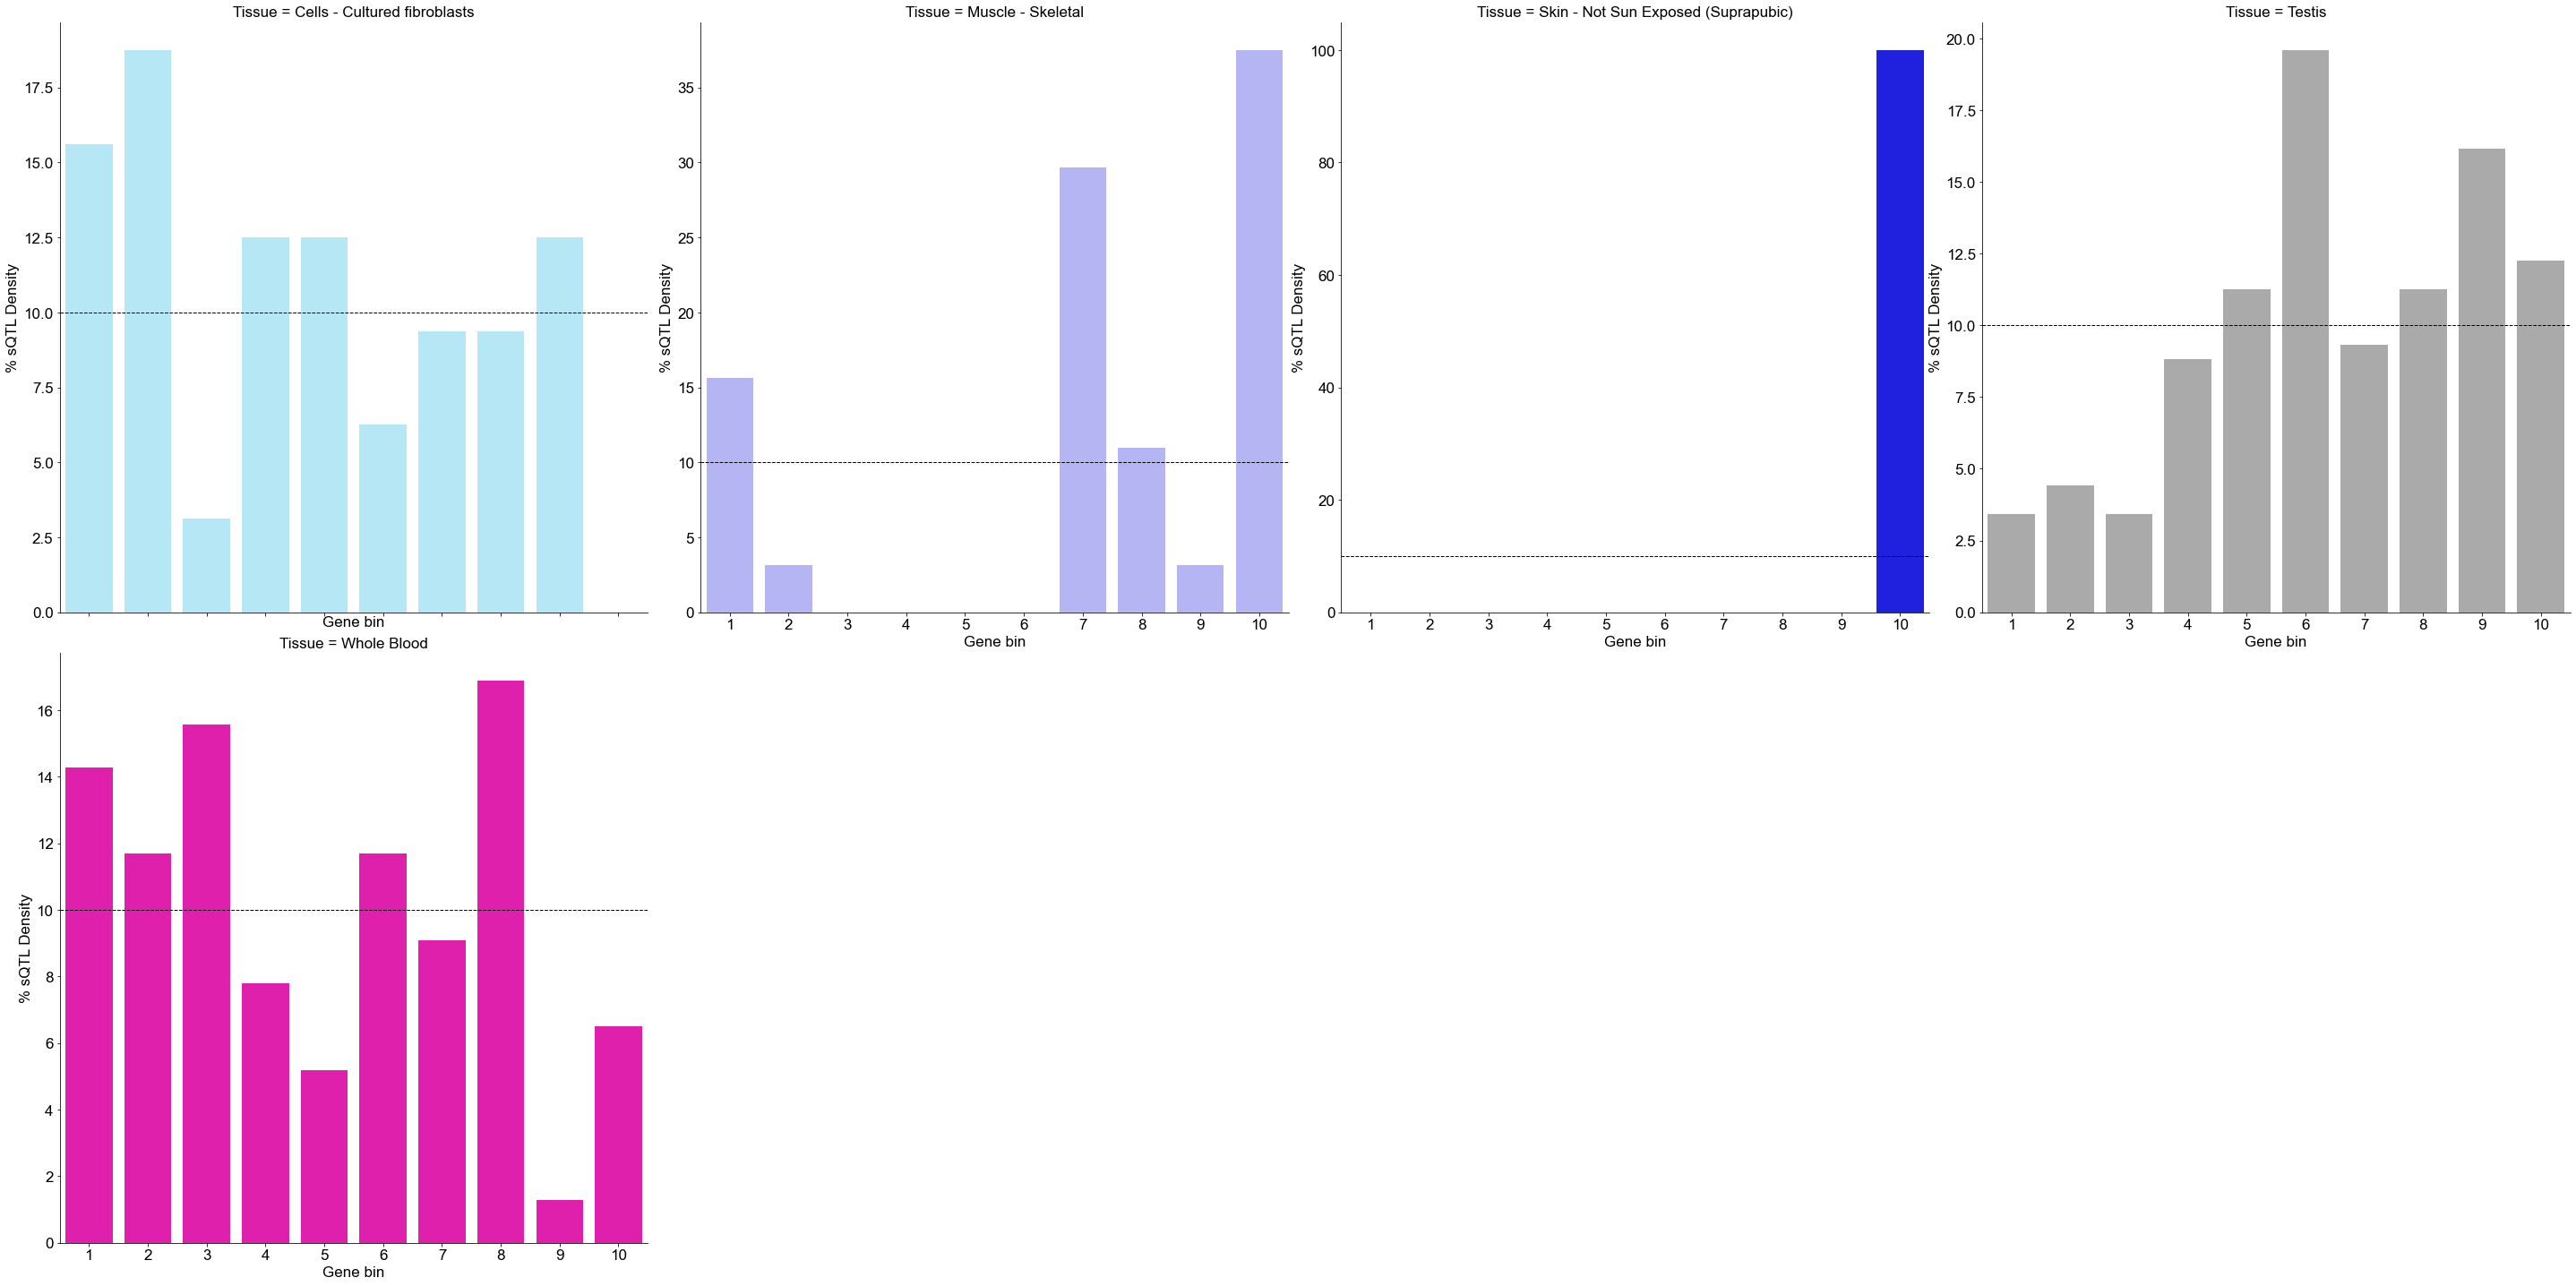

In [355]:

min_max = 'up'

i = 1

def compute_sqtl_ratio(tissue, l) :
    tmp_l = list()
    exotic_cutoffs = [0.9]
    
    for exotic_cutoff in exotic_cutoffs:
        sqtl_deduplicated_up_total = sqtl_deduplicated.loc[(sqtl_deduplicated['EXOTIC_{}'.format(min_max)] > exotic_cutoff)].explode('EXOTIC_tissues_{}'.format(min_max))
        sqtl_deduplicated_up_total.loc[sqtl_deduplicated_up_total['Tissue'] == sqtl_deduplicated_up_total['EXOTIC_tissues_{}'.format(min_max)], 'Match_tissue'] = True
        sqtl_deduplicated_up_total.loc[sqtl_deduplicated_up_total['Tissue'] != sqtl_deduplicated_up_total['EXOTIC_tissues_{}'.format(min_max)], 'Match_tissue'] = False
        sqtl_deduplicated_up_total = sqtl_deduplicated_up_total.loc[sqtl_deduplicated_up_total['Match_tissue'] == True]
        sqtl_deduplicated_up_tissue = sqtl_deduplicated_up_total.loc[sqtl_deduplicated_up_total['Tissue'] == tissue]

        tmp_d = {k:v for k,v in dict(collections.Counter([",".join([str(sub_e) for sub_e in e ]) for e in sqtl_deduplicated_up_tissue.loc[sqtl_deduplicated_up_tissue['Match_tissue'] == True][['snpId', 'snpId_bin']].drop_duplicates(subset=['snpId']).snpId_bin.values.tolist()])).items()}
        if tmp_d:
#             print(tmp_d)

            tmp_d = [[v if int(e) == 1 else 0 for e in k.split(',')] for k,v in tmp_d.items()]
            tmp_df = pd.DataFrame(tmp_d)
#             print(tissue, exotic_cutoff)
#             print(tmp_df)
            tmp_df.columns = [str(e) for e in range(1, nb_bin + 1, 1)]

            tmp_df.loc['Total'] = tmp_df.sum(axis=0)
            tmp_df.loc['Ratio'] = 100 * (tmp_df.loc['Total'] / tmp_df.loc['Total'].sum())
            tmp_df.columns = [str(e) for e in range(1,nb_bin +1 ,1)]
            tmp_l.append(tmp_df.tail(2))

    if tmp_l:
        concat_df_distribution =  pd.concat(tmp_l, keys=exotic_cutoffs, axis=0)
#         concat_df_distribution.to_excel('/gstock/EXOTIC/data/EXOTIC/sQTL_EXOTIC_{}_density_exons_{}_bins.xlsx'.format(min_max, str(nb_bin)))
        concat_df_distribution_ratios = concat_df_distribution.reset_index()
        concat_df_distribution_ratios = concat_df_distribution_ratios.loc[concat_df_distribution_ratios['level_1'] == 'Ratio']
        concat_df_distribution_ratios = concat_df_distribution_ratios.melt(id_vars='level_0', value_vars=[str(e) for e in range(1,nb_bin + 1,1)])
        concat_df_distribution_ratios['Tissue'] = tissue
    #     concat_df_distribution_ratios.columns = [str(e) for e in range(1, nb_bin + 1, 1)]
        l.append(concat_df_distribution_ratios)

        
tissues = sorted(sqtl_deduplicated.Tissue.unique().tolist())
m = multiprocessing.Manager()
l = m.list()
parmap.starmap(compute_sqtl_ratio, list(zip(tissues)), l, pm_pbar=True)

concat_df_distribution_ratios = pd.concat(list(l))
    
print(concat_df_distribution_ratios)

from colour import Color
# Color('red')
palette = gtex_colors[['Tissue', 'Color']].set_index('Tissue').to_dict()['Color']
plt.rcParams.update({'font.size' : 17})
g = sns.FacetGrid(data=concat_df_distribution_ratios, col='Tissue', hue='Tissue', col_wrap=4, col_order=[t for t in tissues if t in concat_df_distribution_ratios.Tissue.unique().tolist()], height=10, sharey=False, palette=palette)
g.map_dataframe(sns.barplot, x='variable', y='value')

# sns.barplot(data=concat_df_distribution_ratios, x='variable', y='value', hue='level_0', palette=palette)
for ax in g.axes.ravel():
    ax.axhline(int(round(100 / nb_bin, 0)), lw=1, ls="--", color='black')
    ax.set_xlabel('Gene bin')
    # plt.xticklabels(pl)
    ax.set_ylabel('% sQTL Density')
    ax.legend().remove()
    ax.spines['top'].set_linewidth(0)
    ax.spines['right'].set_linewidth(0)


100%|██████████| 49/49 [00:01<00:00, 26.33it/s]


    level_0 variable  value                               Tissue
0       0.8        1  100.0  Cells - EBV-transformed lymphocytes
1       0.8        2    0.0  Cells - EBV-transformed lymphocytes
2       0.8        3    0.0  Cells - EBV-transformed lymphocytes
3       0.8        4    0.0  Cells - EBV-transformed lymphocytes
4       0.8        5    0.0  Cells - EBV-transformed lymphocytes
..      ...      ...    ...                                  ...
5       0.8        6    0.0                             Pancreas
6       0.8        7    0.0                             Pancreas
7       0.8        8    0.0                             Pancreas
8       0.8        9    0.0                             Pancreas
9       0.8       10    0.0                             Pancreas

[130 rows x 4 columns]


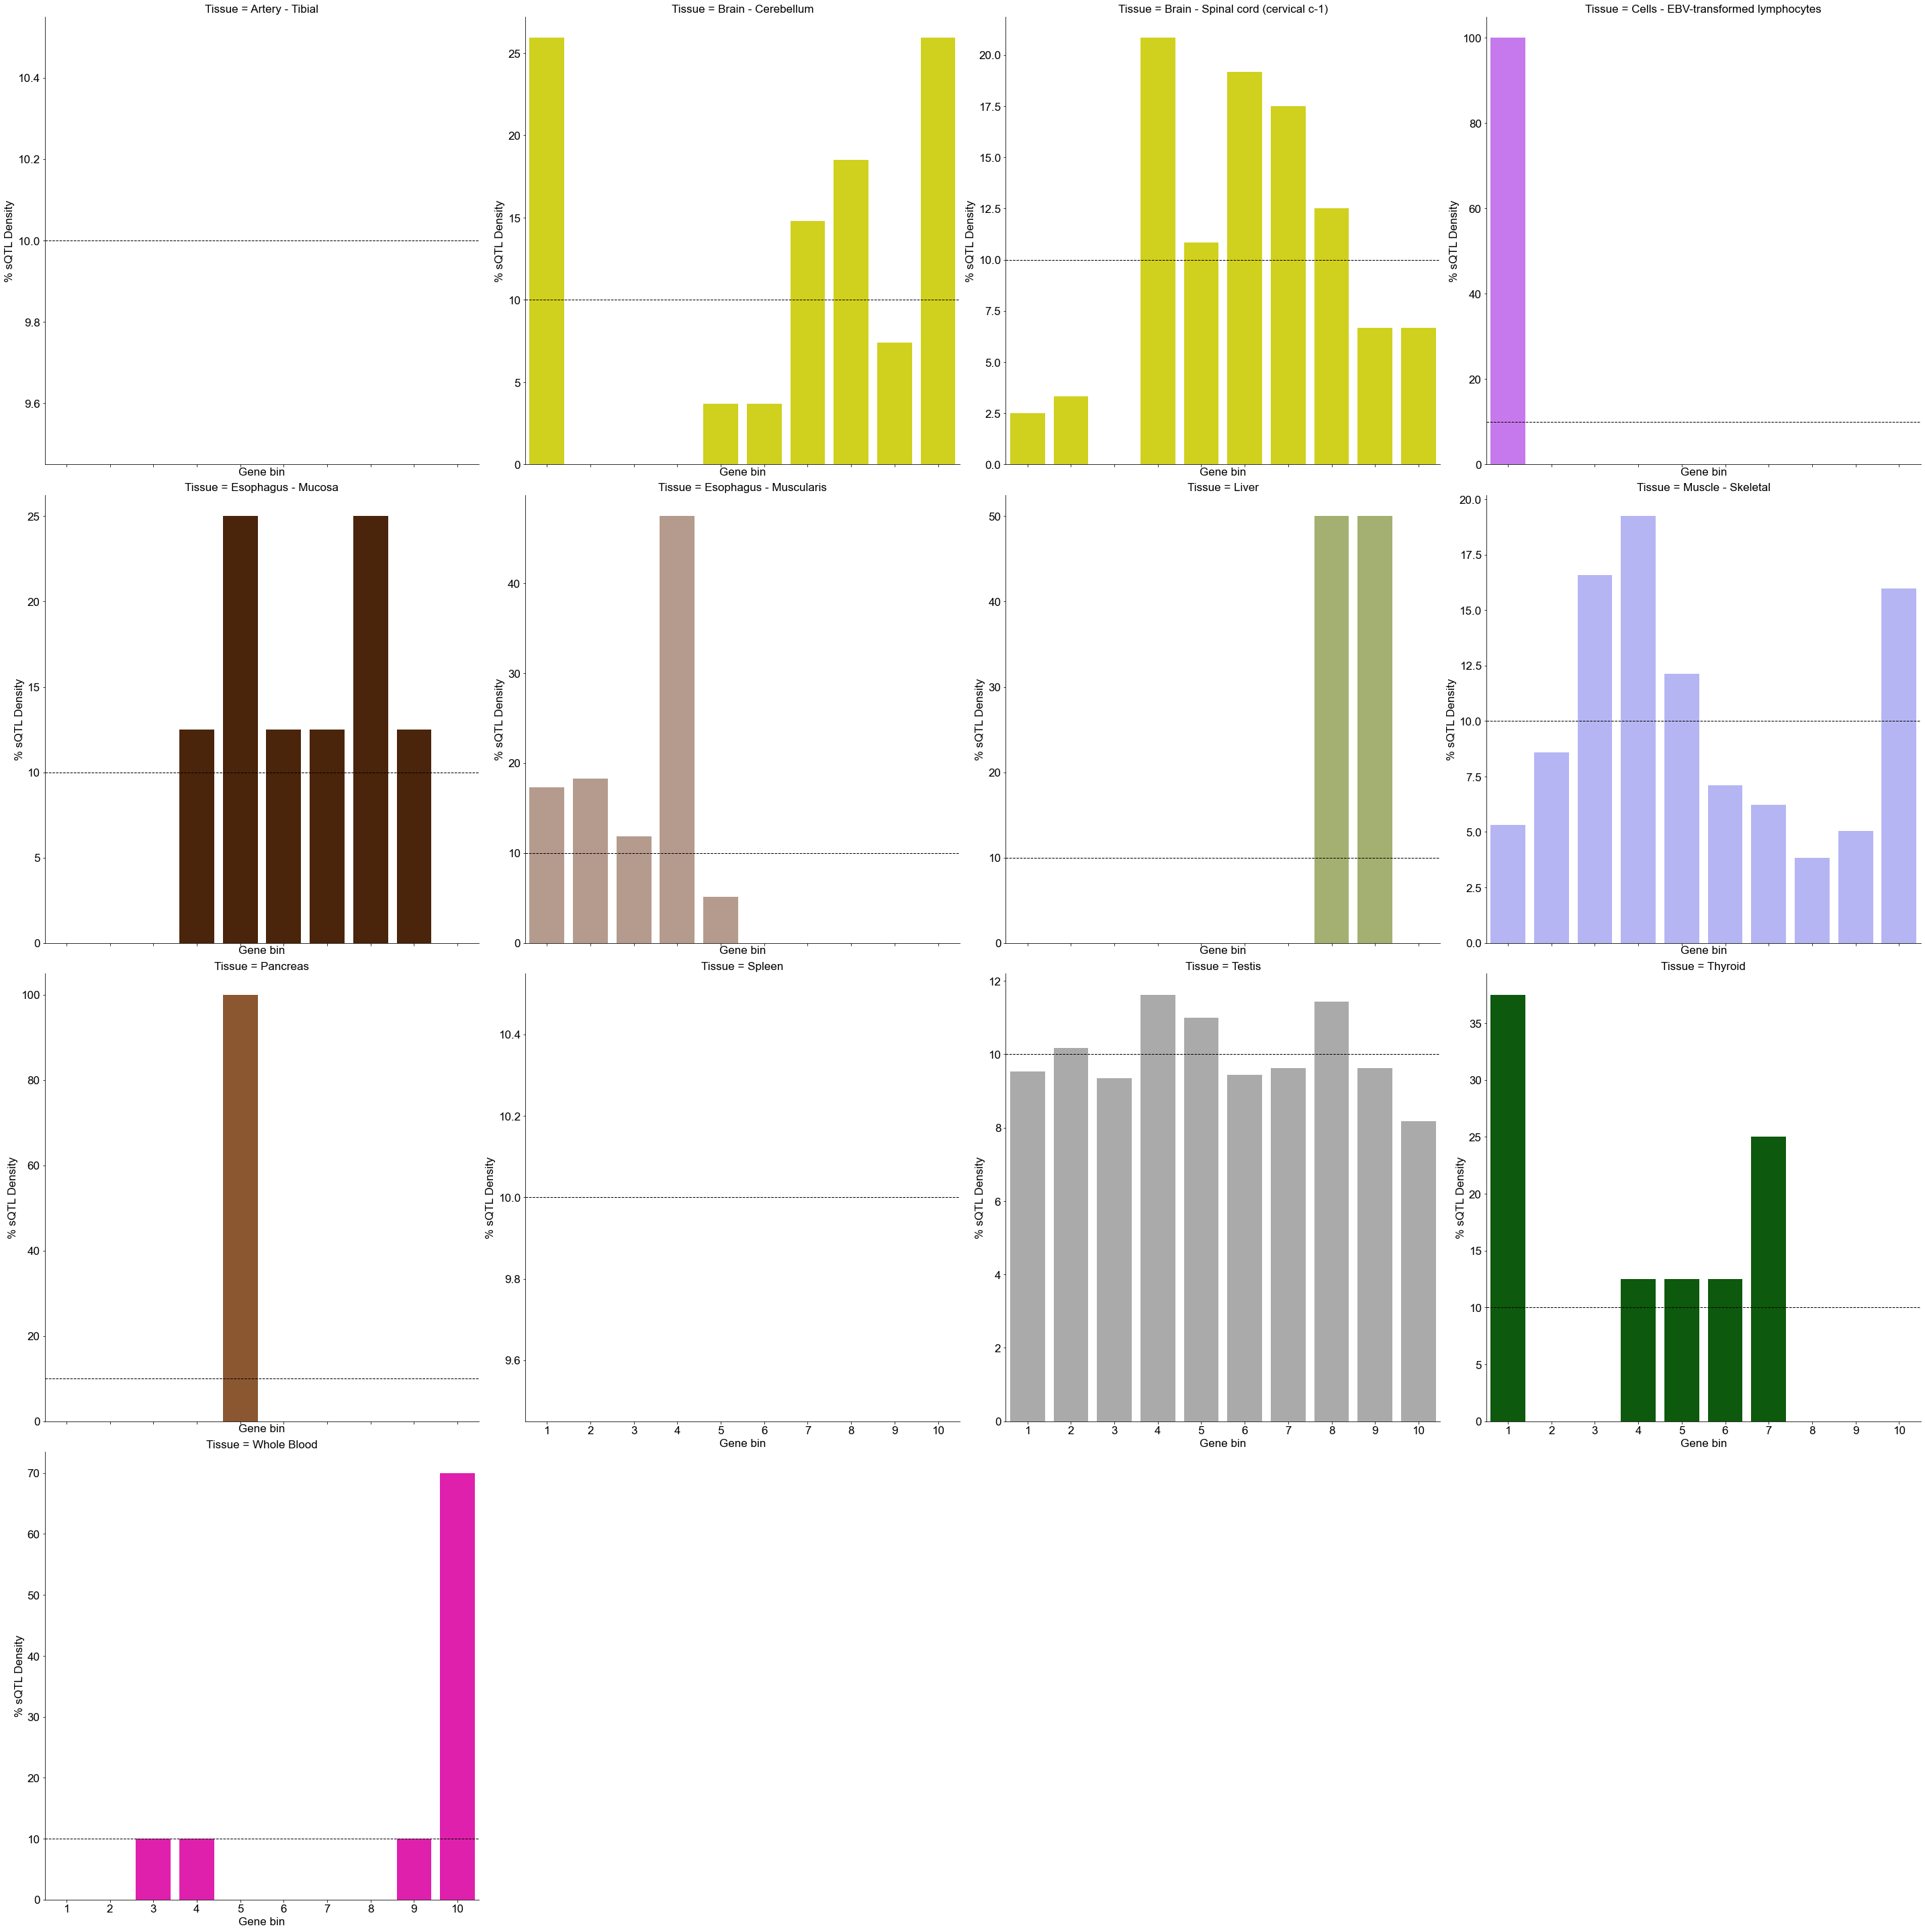

In [356]:

min_max = 'down'

i = 1

def compute_sqtl_ratio(tissue, l) :
    tmp_l = list()
    exotic_cutoffs = [0.8]
    
    for exotic_cutoff in exotic_cutoffs:
        sqtl_deduplicated_up_total = sqtl_deduplicated.loc[(sqtl_deduplicated['EXOTIC_{}'.format(min_max)] > exotic_cutoff)].explode('EXOTIC_tissues_{}'.format(min_max))
        sqtl_deduplicated_up_total.loc[sqtl_deduplicated_up_total['Tissue'] == sqtl_deduplicated_up_total['EXOTIC_tissues_{}'.format(min_max)], 'Match_tissue'] = True
        sqtl_deduplicated_up_total.loc[sqtl_deduplicated_up_total['Tissue'] != sqtl_deduplicated_up_total['EXOTIC_tissues_{}'.format(min_max)], 'Match_tissue'] = False
        sqtl_deduplicated_up_total = sqtl_deduplicated_up_total.loc[sqtl_deduplicated_up_total['Match_tissue'] == True]
        sqtl_deduplicated_up_tissue = sqtl_deduplicated_up_total.loc[sqtl_deduplicated_up_total['Tissue'] == tissue]

        tmp_d = {k:v for k,v in dict(collections.Counter([",".join([str(sub_e) for sub_e in e ]) for e in sqtl_deduplicated_up_tissue.loc[sqtl_deduplicated_up_tissue['Match_tissue'] == True][['snpId', 'snpId_bin']].drop_duplicates(subset=['snpId']).snpId_bin.values.tolist()])).items()}
        if tmp_d:
#             print(tmp_d)

            tmp_d = [[v if int(e) == 1 else 0 for e in k.split(',')] for k,v in tmp_d.items()]
            tmp_df = pd.DataFrame(tmp_d)
#             print(tissue, exotic_cutoff)
#             print(tmp_df)
            tmp_df.columns = [str(e) for e in range(1, nb_bin + 1, 1)]

            tmp_df.loc['Total'] = tmp_df.sum(axis=0)
            tmp_df.loc['Ratio'] = 100 * (tmp_df.loc['Total'] / tmp_df.loc['Total'].sum())
            tmp_df.columns = [str(e) for e in range(1,nb_bin +1 ,1)]
            tmp_l.append(tmp_df.tail(2))

    if tmp_l:
        concat_df_distribution =  pd.concat(tmp_l, keys=exotic_cutoffs, axis=0)
#         concat_df_distribution.to_excel('/gstock/EXOTIC/data/EXOTIC/sQTL_EXOTIC_{}_density_exons_{}_bins.xlsx'.format(min_max, str(nb_bin)))
        concat_df_distribution_ratios = concat_df_distribution.reset_index()
        concat_df_distribution_ratios = concat_df_distribution_ratios.loc[concat_df_distribution_ratios['level_1'] == 'Ratio']
        concat_df_distribution_ratios = concat_df_distribution_ratios.melt(id_vars='level_0', value_vars=[str(e) for e in range(1,nb_bin + 1,1)])
        concat_df_distribution_ratios['Tissue'] = tissue
    #     concat_df_distribution_ratios.columns = [str(e) for e in range(1, nb_bin + 1, 1)]
        l.append(concat_df_distribution_ratios)

        
tissues = sorted(sqtl_deduplicated.Tissue.unique().tolist())
m = multiprocessing.Manager()
l = m.list()
parmap.starmap(compute_sqtl_ratio, list(zip(tissues)), l, pm_pbar=True)

concat_df_distribution_ratios = pd.concat(list(l))
    
print(concat_df_distribution_ratios)

from colour import Color
# Color('red')
palette = gtex_colors[['Tissue', 'Color']].set_index('Tissue').to_dict()['Color']
plt.rcParams.update({'font.size' : 17})
g = sns.FacetGrid(data=concat_df_distribution_ratios, col='Tissue', hue='Tissue', col_wrap=4, col_order=[t for t in tissues if t in concat_df_distribution_ratios.Tissue.unique().tolist()], height=10, sharey=False, palette=palette)
g.map_dataframe(sns.barplot, x='variable', y='value')

# sns.barplot(data=concat_df_distribution_ratios, x='variable', y='value', hue='level_0', palette=palette)
for ax in g.axes.ravel():
    ax.axhline(int(round(100 / nb_bin, 0)), lw=1, ls="--", color='black')
    ax.set_xlabel('Gene bin')
    # plt.xticklabels(pl)
    ax.set_ylabel('% sQTL Density')
    ax.legend().remove()
    ax.spines['top'].set_linewidth(0)
    ax.spines['right'].set_linewidth(0)


100%|██████████| 49/49 [00:02<00:00, 23.38it/s]


    level_0 variable      value                  Tissue
4       0.8        5  13.072626  Adipose - Subcutaneous
0       0.8        1   8.789572  Adipose - Subcutaneous
3       0.8        4  11.210428  Adipose - Subcutaneous
1       0.8        2   8.640596  Adipose - Subcutaneous
5       0.8        6  12.327747  Adipose - Subcutaneous
..      ...      ...        ...                     ...
3       0.8        4   9.330629             Whole Blood
2       0.8        3   9.939148             Whole Blood
1       0.8        2   2.434077             Whole Blood
0       0.8        1   6.896552             Whole Blood
9       0.8       10   6.896552             Whole Blood

[490 rows x 4 columns]


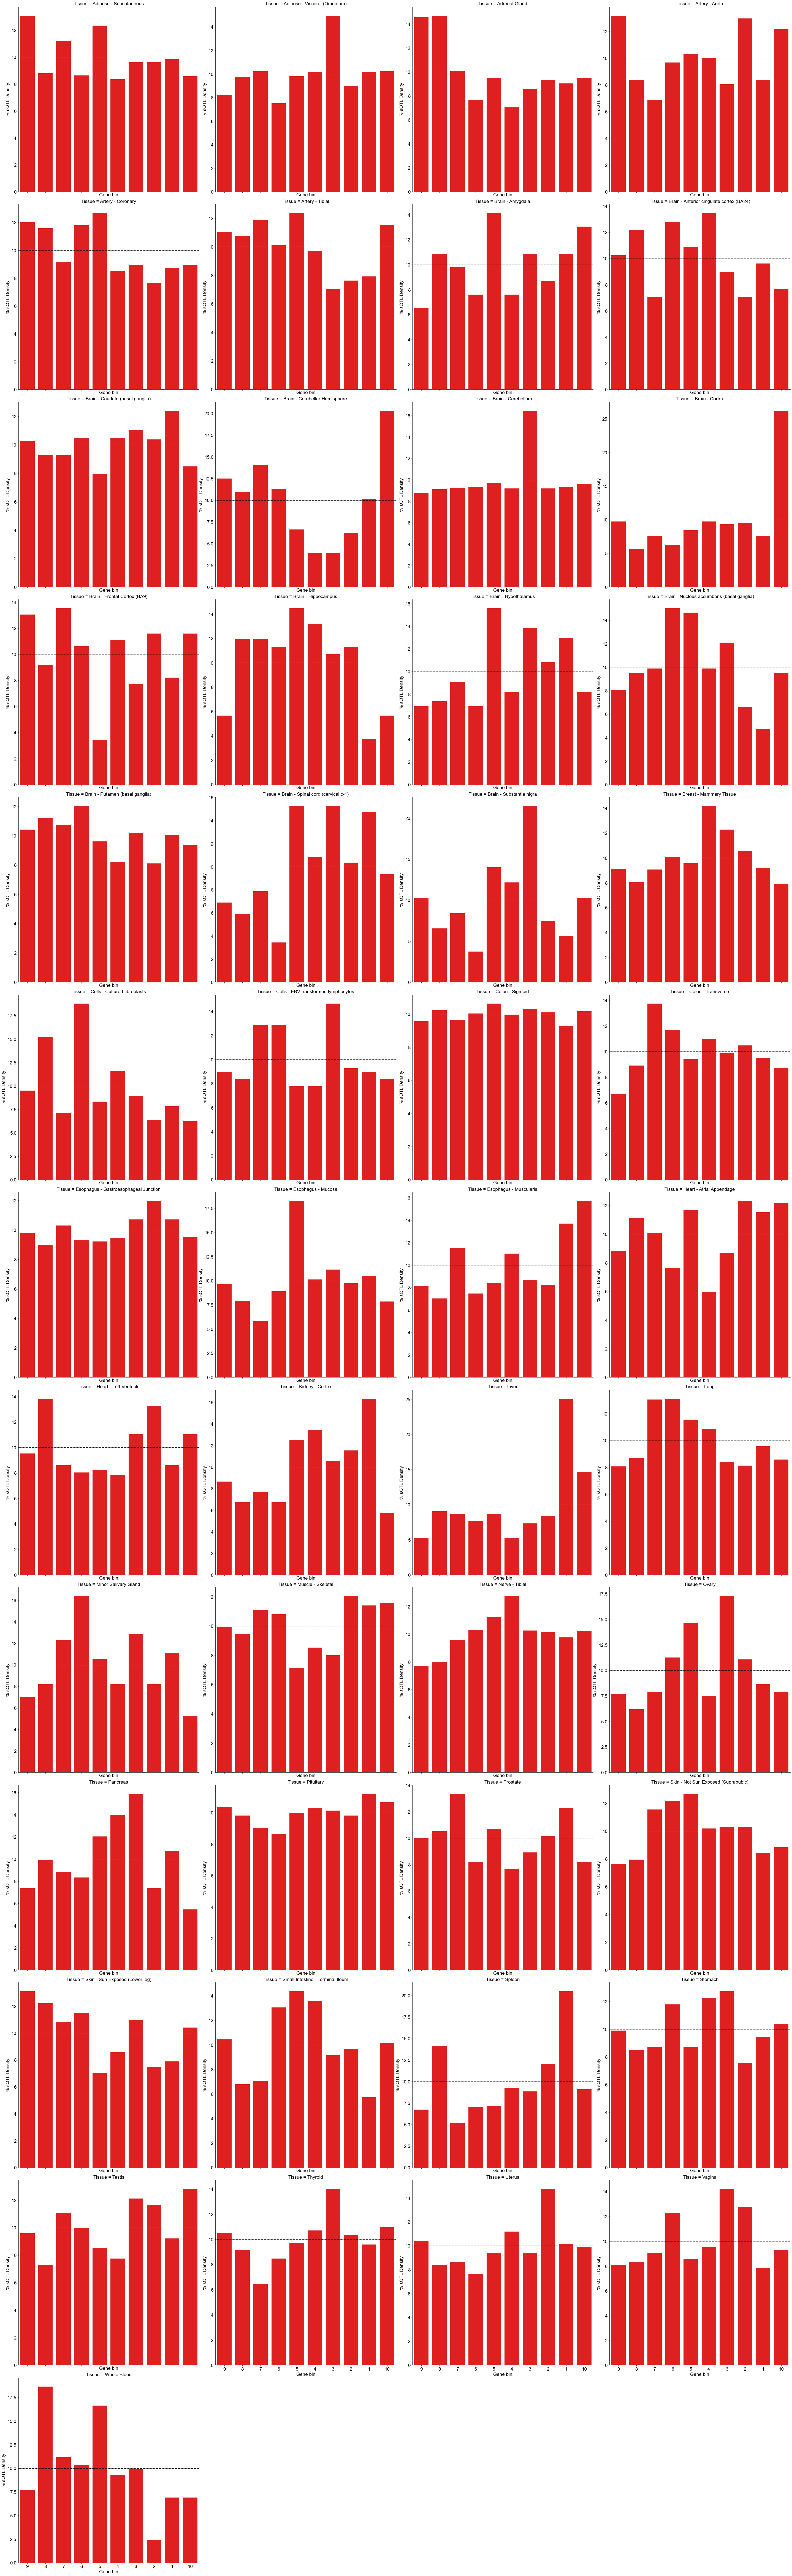

In [311]:

min_max = 'up'

i = 1

def compute_sqtl_ratio(tissue, l) :
    tmp_l = list()
    exotic_cutoffs = [0.8]
    
    for exotic_cutoff in exotic_cutoffs:
        sqtl_deduplicated_up_total = sqtl_deduplicated.loc[(sqtl_deduplicated['EXOTIC_{}'.format(min_max)] > exotic_cutoff)].explode('EXOTIC_tissues_{}'.format(min_max))
        sqtl_deduplicated_up_total.loc[sqtl_deduplicated_up_total['Tissue'] == sqtl_deduplicated_up_total['EXOTIC_tissues_{}'.format(min_max)], 'Match_tissue'] = True
        sqtl_deduplicated_up_total.loc[sqtl_deduplicated_up_total['Tissue'] != sqtl_deduplicated_up_total['EXOTIC_tissues_{}'.format(min_max)], 'Match_tissue'] = False
        sqtl_deduplicated_up_total = sqtl_deduplicated_up_total.loc[sqtl_deduplicated_up_total['Match_tissue'] == False]
        sqtl_deduplicated_up_tissue = sqtl_deduplicated_up_total.loc[sqtl_deduplicated_up_total['Tissue'] == tissue]

        tmp_d = {k:v for k,v in dict(collections.Counter([",".join([str(sub_e) for sub_e in e ]) for e in sqtl_deduplicated_up_tissue.loc[sqtl_deduplicated_up_tissue['Match_tissue'] == False][['snpId', 'snpId_bin']].drop_duplicates(subset=['snpId']).snpId_bin.values.tolist()])).items()}
        if tmp_d:
#             print(tmp_d)

            tmp_d = [[v if int(e) == 1 else 0 for e in k.split(',')] for k,v in tmp_d.items()]
            tmp_df = pd.DataFrame(tmp_d)
#             print(tissue, exotic_cutoff)
#             print(tmp_df)
            tmp_df.columns = [str(e) for e in range(1, nb_bin + 1, 1)]

            tmp_df.loc['Total'] = tmp_df.sum(axis=0)
            tmp_df.loc['Ratio'] = 100 * (tmp_df.loc['Total'] / tmp_df.loc['Total'].sum())
            tmp_df.columns = [str(e) for e in range(1,nb_bin +1 ,1)]
            tmp_l.append(tmp_df.tail(2))

    if tmp_l:
        concat_df_distribution =  pd.concat(tmp_l, keys=exotic_cutoffs, axis=0)
        concat_df_distribution.to_excel('/gstock/EXOTIC/data/EXOTIC/sQTL_EXOTIC_{}_density_exons_{}_bins.xlsx'.format(min_max, str(nb_bin)))
        concat_df_distribution_ratios = concat_df_distribution.reset_index()
        concat_df_distribution_ratios = concat_df_distribution_ratios.loc[concat_df_distribution_ratios['level_1'] == 'Ratio']
        concat_df_distribution_ratios = concat_df_distribution_ratios.melt(id_vars='level_0', value_vars=[str(e) for e in range(1,nb_bin + 1,1)])
        concat_df_distribution_ratios['Tissue'] = tissue
    #     concat_df_distribution_ratios.columns = [str(e) for e in range(1, nb_bin + 1, 1)]
        l.append(concat_df_distribution_ratios)

        
tissues = sorted(sqtl_deduplicated.Tissue.unique().tolist())
m = multiprocessing.Manager()
l = m.list()
parmap.starmap(compute_sqtl_ratio, list(zip(tissues)), l, pm_pbar=True)

concat_df_distribution_ratios = pd.concat(list(l))
concat_df_distribution_ratios = concat_df_distribution_ratios.sort_values(by='Tissue')
    
print(concat_df_distribution_ratios)

from colour import Color
# Color('red')
palette = ['#f19999', '#e64c4c', '#dc0000',]
plt.rcParams.update({'font.size' : 17})
g = sns.FacetGrid(data=concat_df_distribution_ratios, col='Tissue', col_wrap=4, height=10, sharey=False)
g.map_dataframe(sns.barplot, x='variable', y='value', hue='level_0',palette=['red'])

# sns.barplot(data=concat_df_distribution_ratios, x='variable', y='value', hue='level_0', palette=palette)
for ax in g.axes.ravel():
    ax.axhline(int(round(100 / nb_bin, 0)), lw=1, ls="--", color='black')
    ax.set_xlabel('Gene bin')
    # plt.xticklabels(pl)
    ax.set_ylabel('% sQTL Density')
    ax.legend().remove()
    ax.spines['top'].set_linewidth(0)
    ax.spines['right'].set_linewidth(0)


In [312]:
tmp_l = list()

min_max = 'down'

exotic_cutoffs = [0.5, 0.8, 0.9]

for exotic_cutoff in tqdm(exotic_cutoffs):
    sqtl_deduplicated_up = sqtl_deduplicated.loc[sqtl_deduplicated['EXOTIC_{}'.format(min_max)] > exotic_cutoff].explode('EXOTIC_tissues_{}'.format(min_max))
    sqtl_deduplicated_up.loc[sqtl_deduplicated_up['Tissue'] == sqtl_deduplicated_up['EXOTIC_tissues_{}'.format(min_max)], 'Match_tissue'] = True
    sqtl_deduplicated_up.loc[sqtl_deduplicated_up['Tissue'] != sqtl_deduplicated_up['EXOTIC_tissues_{}'.format(min_max)], 'Match_tissue'] = False
    sqtl_deduplicated_up.head()

    tmp_d = {k:v for k,v in dict(collections.Counter([",".join([str(sub_e) for sub_e in e ]) for e in sqtl_deduplicated_up.loc[sqtl_deduplicated_up['Match_tissue'] == True][['snpId', 'snpId_bin']].drop_duplicates(subset=['snpId']).snpId_bin.values.tolist()])).items() if v > 10}
    tmp_d = [[v if int(e) == 1 else 0 for e in k.split(',')] for k,v in tmp_d.items()]
    tmp_df = pd.DataFrame(tmp_d)
    tmp_df.loc['Total'] = tmp_df.sum(axis=0)
    tmp_df.loc['Ratio'] = 100 * (tmp_df.loc['Total'] / tmp_df.loc['Total'].sum())
    tmp_df.columns = [str(e) for e in range(1,nb_bin +1 ,1)]
    tmp_l.append(tmp_df.tail(2))

concat_df_distribution =  pd.concat(tmp_l, keys=exotic_cutoffs, axis=0)
concat_df_distribution.to_excel('/gstock/EXOTIC/data/EXOTIC/sQTL_EXOTIC_{}_density_exons_{}_bins.xlsx'.format(min_max, str(nb_bin)))
concat_df_distribution_ratios = concat_df_distribution.reset_index()
concat_df_distribution_ratios = concat_df_distribution_ratios.loc[concat_df_distribution_ratios['level_1'] == 'Ratio']
concat_df_distribution_ratios = concat_df_distribution_ratios.melt(id_vars='level_0', value_vars=[str(e) for e in range(1,nb_bin + 1,1)])
concat_df_distribution_ratios.head()
concat_df_distribution_ratios = concat_df_distribution_ratios.sort_values(by='Tissue')

print(concat_df_distribution_ratios)

from colour import Color
# Color('red')
palette = ['#f19999', '#e64c4c', '#dc0000',]
plt.rcParams.update({'font.size' : 17})
f, ax = plt.subplots(figsize=(15,10))
sns.barplot(data=concat_df_distribution_ratios, x='variable', y='value', hue='level_0', palette=palette)
plt.axhline(int(round(100 / nb_bin, 0)), lw=1, ls="--", color='black')
plt.xlabel('Gene bin')
# plt.xticklabels(pl)
plt.ylabel('% sQTL Density')
ax.legend(title='EXOTIC-{} cutoff'.format(min_max))
ax.spines['top'].set_linewidth(0)
ax.spines['right'].set_linewidth(0)


100%|██████████| 3/3 [00:09<00:00,  3.14s/it]


KeyError: 'Tissue'

   index variable      value
0  Ratio        1   7.804878
1  Ratio        2   8.219052
2  Ratio        3   8.854119
3  Ratio        4   9.792913
4  Ratio        5  12.268753
5  Ratio        6  12.673723
6  Ratio        7  11.145881
7  Ratio        8  10.381960
8  Ratio        9   9.047400
9  Ratio       10   9.811321


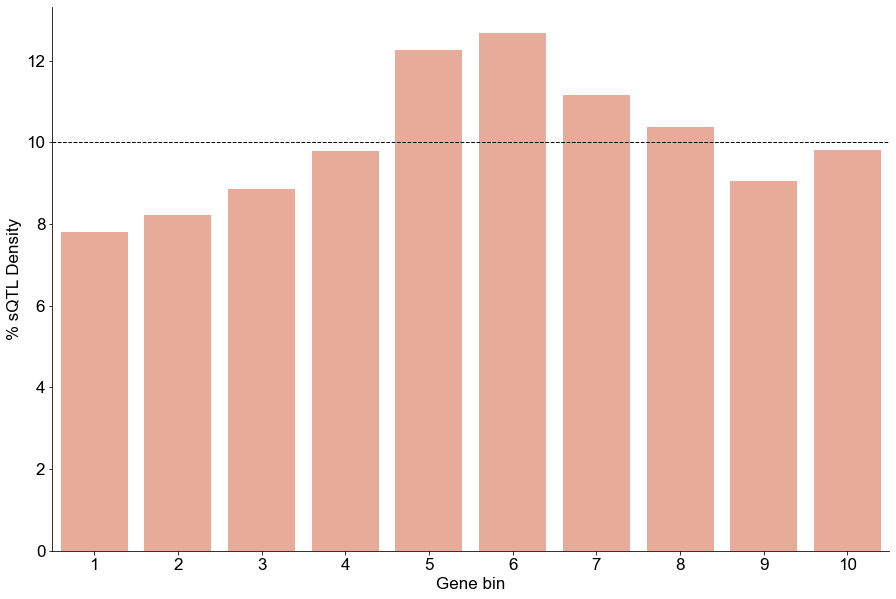

In [257]:
tmp_d = {k:v for k,v in dict(collections.Counter([",".join([str(sub_e) for sub_e in e ]) for e in sqtl_deduplicated_up.loc[sqtl_deduplicated_up['Match_tissue'] == False][['snpId', 'snpId_bin']].drop_duplicates(subset=['snpId']).snpId_bin.values.tolist()])).items() if v > 10}
tmp_d = [[v if int(e) == 1 else 0 for e in k.split(',')] for k,v in tmp_d.items()]
tmp_df = pd.DataFrame(tmp_d)
tmp_df.loc['Total'] = tmp_df.sum(axis=0)
tmp_df.loc['Ratio'] = 100 * (tmp_df.loc['Total'] / tmp_df.loc['Total'].sum())
tmp_df.columns = [str(e) for e in range(1,nb_bin +1 ,1)]
concat_df_distribution = tmp_df.tail(2)
tmp_df

concat_df_distribution_ratios = concat_df_distribution.reset_index()
concat_df_distribution_ratios = concat_df_distribution_ratios.loc[concat_df_distribution_ratios['index'] == 'Ratio']
concat_df_distribution_ratios = concat_df_distribution_ratios.melt(id_vars='index', value_vars=[str(e) for e in range(1,nb_bin + 1,1)])
concat_df_distribution_ratios.head()

print(concat_df_distribution_ratios)

from colour import Color
# Color('red')
palette = ['#b1bacf', '#7687ab', '#3c5488']
plt.rcParams.update({'font.size' : 17})
f, ax = plt.subplots(figsize=(15,10))
sns.barplot(data=concat_df_distribution_ratios, x='variable', y='value', hue='index', palette=['#F39B7FFF'], alpha=0.9)
plt.axhline(int(round(100 / nb_bin, 0)), lw=1, ls="--", color='black')
plt.xlabel('Gene bin')
# plt.xticklabels(pl)
plt.ylabel('% sQTL Density')
ax.legend().remove()
ax.spines['top'].set_linewidth(0)
ax.spines['right'].set_linewidth(0)


In [ ]:
merge_exotic_sqtl_38 =  pd.merge(merge_exotic_sqtl, exotic_37_38[['MAP', 'MAP_38']], on='MAP')
merge_exotic_sqtl_38.to_parquet('/gstock/EXOTIC/data/QTL/EXOTIC_sQTL_38.parquet')
merge_exotic_sqtl_38

In [62]:
merge_exotic_sqtl_38_exploded_up = merge_exotic_sqtl_38.explode('EXOTIC_tissues_up')
merge_exotic_sqtl_38_exploded_up.loc[merge_exotic_sqtl_38_exploded_up['Tissue'] == merge_exotic_sqtl_38_exploded_up['EXOTIC_tissues_up'], 'Match_tissues'] = True
merge_exotic_sqtl_38_exploded_up.loc[merge_exotic_sqtl_38_exploded_up['Tissue'] != merge_exotic_sqtl_38_exploded_up['EXOTIC_tissues_up'], 'Match_tissues'] = False
merge_exotic_sqtl_38_exploded_up

,symbol,ensg,HGNC,Exon,Ratio_num,mRNA_nb,mRNA_nb_total,MAP,mean_proportion,Adipose - Subcutaneous,...,pv.svQTL,fdr.svQTL,tr_type,ENST,Tissue,gene_id,nb.perm,pv.emp.perm,MAP_38,Match_tissues
0,A2ML1,ENSG00000166535,23336,8975248-8975309,0.5,1,2,A2ML1_8975248-8975309,0.69514,0.578349,...,0.231759,0.675328,tr.second,ENST00000299698,Testis,ENSG00000166535,1000.0,0.000999,A2ML1_8822652-8822713,False
0,A2ML1,ENSG00000166535,23336,8975248-8975309,0.5,1,2,A2ML1_8975248-8975309,0.69514,0.578349,...,0.231759,0.675328,tr.second,ENST00000299698,Testis,ENSG00000166535,1000.0,0.000999,A2ML1_8822652-8822713,False
0,A2ML1,ENSG00000166535,23336,8975248-8975309,0.5,1,2,A2ML1_8975248-8975309,0.69514,0.578349,...,0.231759,0.675328,tr.second,ENST00000299698,Testis,ENSG00000166535,1000.0,0.000999,A2ML1_8822652-8822713,False
0,A2ML1,ENSG00000166535,23336,8975248-8975309,0.5,1,2,A2ML1_8975248-8975309,0.69514,0.578349,...,0.231759,0.675328,tr.second,ENST00000299698,Testis,ENSG00000166535,1000.0,0.000999,A2ML1_8822652-8822713,False
0,A2ML1,ENSG00000166535,23336,8975248-8975309,0.5,1,2,A2ML1_8975248-8975309,0.69514,0.578349,...,0.231759,0.675328,tr.second,ENST00000299698,Testis,ENSG00000166535,1000.0,0.000999,A2ML1_8822652-8822713,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5037416,ZXDC,ENSG00000070476,28160,126158475-126158570,0.5,1,2,ZXDC_126158475-126158570,0.20989,0.500250,...,0.332937,0.746733,tr.second,ENST00000389709,Skin - Sun Exposed (Lower leg),ENSG00000070476,1000.0,0.000999,ZXDC_126439632-126439727,False
5037417,ZXDC,ENSG00000070476,28160,126158475-126158570,0.5,1,2,ZXDC_126158475-126158570,0.20989,0.500250,...,0.332937,0.746733,tr.second,ENST00000389709,Skin - Sun Exposed (Lower leg),ENSG00000070476,1000.0,0.000999,ZXDC_126439632-126439727,False
5037418,ZXDC,ENSG00000070476,28160,126158475-126158570,0.5,1,2,ZXDC_126158475-126158570,0.20989,0.500250,...,0.332937,0.746733,tr.second,ENST00000389709,Skin - Sun Exposed (Lower leg),ENSG00000070476,1000.0,0.000999,ZXDC_126439632-126439727,False
5037419,ZXDC,ENSG00000070476,28160,126158475-126158570,0.5,1,2,ZXDC_126158475-126158570,0.20989,0.500250,...,0.332937,0.746733,tr.second,ENST00000389709,Skin - Sun Exposed (Lower leg),ENSG00000070476,1000.0,0.000999,ZXDC_126439632-126439727,False


In [63]:
merge_exotic_sqtl_38_exploded_up.Match_tissues.value_counts()

False    7736374
True      132028
Name: Match_tissues, dtype: int64

In [38]:
merge_exotic_sqtl_38_exploded_up.snpId

6382       17_81158861_CA_C_b38
6384       17_81158861_CA_C_b38
6386       17_81158861_CA_C_b38
16186       18_21689365_G_A_b38
16189       18_21692808_G_A_b38
                   ...         
5036938      6_28348098_T_C_b38
5036940      6_28326773_T_C_b38
5036941      6_28324929_T_C_b38
5036945      6_28358713_A_G_b38
5036962      6_28356161_T_C_b38
Name: snpId, Length: 967845, dtype: object

In [83]:
merge_exotic_sqtl_38_exploded_up = pd.read_parquet('/gstock/EXOTIC/data/EXOTIC_sQTL_38_exploded_up_tissues.parquet', index=False)


In [64]:
tqdm.pandas()

def compute_distance(r):
#     print(r)
    sqtl_pos = int(r['snpId_POS'])
    exon_start = int(r['Exon_start_38'])
    exon_end = int(r['Exon_end_38'])
    if sqtl_pos >= exon_start and sqtl_pos <= exon_end:
        return 0
    else:
        distance_start = np.abs(exon_start - sqtl_pos)
        distance_end = np.abs(exon_end - sqtl_pos)
        return min([distance_start, distance_end])

merge_exotic_sqtl_38_exploded_up['snpId_POS'] = merge_exotic_sqtl_38_exploded_up.snpId.apply(lambda r: int(r.split('_')[1]))
merge_exotic_sqtl_38_exploded_up['Exon_start_38'] = merge_exotic_sqtl_38_exploded_up.MAP_38.apply(lambda r: int(r.split('_')[1].split('-')[0]))
merge_exotic_sqtl_38_exploded_up['Exon_end_38'] = merge_exotic_sqtl_38_exploded_up.MAP_38.apply(lambda r: int(r.split('_')[1].split('-')[1]))

merge_exotic_sqtl_38_exploded_up['Shortest_distance_snpid_exon'] = merge_exotic_sqtl_38_exploded_up[['snpId_POS', 'Exon_start_38', 'Exon_end_38']].progress_apply(lambda r: compute_distance(r), axis=1)
merge_exotic_sqtl_38_exploded_up.to_parquet('/gstock/EXOTIC/data/EXOTIC_sQTL_38_exploded_up_tissues.parquet', index=False)
merge_exotic_sqtl_38_exploded_up

/home/weber/.conda/envs/ExoCarto/lib/python3.7/site-packages/tqdm/std.py:668: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel
100%|██████████| 7868402/7868402 [12:16<00:00, 10682.80it/s]


,symbol,ensg,HGNC,Exon,Ratio_num,mRNA_nb,mRNA_nb_total,MAP,mean_proportion,Adipose - Subcutaneous,...,Tissue,gene_id,nb.perm,pv.emp.perm,MAP_38,Match_tissues,snpId_POS,Exon_start_38,Exon_end_38,Shortest_distance_snpid_exon
0,A2ML1,ENSG00000166535,23336,8975248-8975309,0.5,1,2,A2ML1_8975248-8975309,0.69514,0.578349,...,Testis,ENSG00000166535,1000.0,0.000999,A2ML1_8822652-8822713,False,8828564,8822652,8822713,5851
0,A2ML1,ENSG00000166535,23336,8975248-8975309,0.5,1,2,A2ML1_8975248-8975309,0.69514,0.578349,...,Testis,ENSG00000166535,1000.0,0.000999,A2ML1_8822652-8822713,False,8828564,8822652,8822713,5851
0,A2ML1,ENSG00000166535,23336,8975248-8975309,0.5,1,2,A2ML1_8975248-8975309,0.69514,0.578349,...,Testis,ENSG00000166535,1000.0,0.000999,A2ML1_8822652-8822713,False,8828564,8822652,8822713,5851
0,A2ML1,ENSG00000166535,23336,8975248-8975309,0.5,1,2,A2ML1_8975248-8975309,0.69514,0.578349,...,Testis,ENSG00000166535,1000.0,0.000999,A2ML1_8822652-8822713,False,8828564,8822652,8822713,5851
0,A2ML1,ENSG00000166535,23336,8975248-8975309,0.5,1,2,A2ML1_8975248-8975309,0.69514,0.578349,...,Testis,ENSG00000166535,1000.0,0.000999,A2ML1_8822652-8822713,False,8828564,8822652,8822713,5851
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5037416,ZXDC,ENSG00000070476,28160,126158475-126158570,0.5,1,2,ZXDC_126158475-126158570,0.20989,0.500250,...,Skin - Sun Exposed (Lower leg),ENSG00000070476,1000.0,0.000999,ZXDC_126439632-126439727,False,126464703,126439632,126439727,24976
5037417,ZXDC,ENSG00000070476,28160,126158475-126158570,0.5,1,2,ZXDC_126158475-126158570,0.20989,0.500250,...,Skin - Sun Exposed (Lower leg),ENSG00000070476,1000.0,0.000999,ZXDC_126439632-126439727,False,126466665,126439632,126439727,26938
5037418,ZXDC,ENSG00000070476,28160,126158475-126158570,0.5,1,2,ZXDC_126158475-126158570,0.20989,0.500250,...,Skin - Sun Exposed (Lower leg),ENSG00000070476,1000.0,0.000999,ZXDC_126439632-126439727,False,126473616,126439632,126439727,33889
5037419,ZXDC,ENSG00000070476,28160,126158475-126158570,0.5,1,2,ZXDC_126158475-126158570,0.20989,0.500250,...,Skin - Sun Exposed (Lower leg),ENSG00000070476,1000.0,0.000999,ZXDC_126439632-126439727,False,126474053,126439632,126439727,34326


In [44]:
merge_exotic_sqtl_38_exploded_up.loc[merge_exotic_sqtl_38_exploded_up['Shortest_distance_snpid_exon'] > 0][['Match_tissues', 'Shortest_distance_snpid_exon']].reset_index(drop=True).pivot(columns='Match_tissues', values='Shortest_distance_snpid_exon').describe()

Match_tissues,False,True
count,9.457510e+05,20217.000000
mean,8.688239e+04,103978.420933
std,1.688710e+05,114468.114679
min,1.000000e+00,1.000000
25%,9.769000e+03,15982.000000
50%,2.753200e+04,59316.000000
75%,1.278940e+05,166184.000000
max,3.660581e+07,603439.000000


In [86]:
data_raw = merge_exotic_sqtl_38_exploded_up.copy()
data_raw = data_raw[['snpId', 'Match_tissues', 'Shortest_distance_snpid_exon', 'EXOTIC_bins_up', 'EXOTIC_up', 'md', 'LD']].drop_duplicates()



min_max = 'up'

# COMPUTE BINS
# r = np.arange(0.5,1.05,0.05)
r = [0.5,0.8,1]
bins = r
labels = bins.copy()
labels_ratio = [str(round(labels[j], 3)) + " - " + str(round(labels[j + 1], 3)) for j in range(len(labels) - 1)]
data_raw["EXOTIC_bins_{}".format(min_max)] = pd.cut(data_raw["EXOTIC_{}".format(min_max)], bins=bins, labels=labels_ratio, include_lowest=True)
# data_raw[['EXOTIC_bins_up', 'Match_tissues', 'Shortest_distance_snpid_exon']].value_counts()
# data_raw[['EXOTIC_bins_up', 'Match_tissues', 'Shortest_distance_snpid_exon']].reset_index(drop=True).pivot(columns=['Match_tissues', 'EXOTIC_bins_up'], values='Shortest_distance_snpid_exon').describe()
# data_raw.loc[(data_raw['Shortest_distance_snpid_exon'] > 0), ['EXOTIC_bins_up', 'Match_tissues', 'Shortest_distance_snpid_exon']].reset_index(drop=True).pivot(columns=['Match_tissues', 'EXOTIC_bins_up'], values='Shortest_distance_snpid_exon').describe()
# data_raw.loc[(data_raw['Shortest_distance_snpid_exon'] > 0) & (data['md'] > 0.2), ['EXOTIC_bins_up', 'Match_tissues', 'Shortest_distance_snpid_exon']].reset_index(drop=True).pivot(columns=['Match_tissues', 'EXOTIC_bins_up'], values='Shortest_distance_snpid_exon').describe()

EXOTIC_bins_up  Match_tissues  Shortest_distance_snpid_exon
0.5 - 0.8       False          0                               4007
                               15301                            256
                               115                              251
                               7083                             247
                               1084                             243
                                                               ... 
                               575441                             1
                               575162                             1
                               575123                             1
                               575084                             1
0.8 - 1         True           1000609                            1
Length: 227086, dtype: int64

In [68]:
data_raw[['EXOTIC_bins_up', 'Match_tissues']].value_counts()


EXOTIC_bins_up  Match_tissues
0.5 - 0.8       False            477893
                True              61787
0.8 - 1         False             43127
                True               3115
dtype: int64

In [74]:
data_raw[['EXOTIC_bins_up', 'Match_tissues', 'Shortest_distance_snpid_exon']].reset_index(drop=True).pivot(columns=['Match_tissues', 'EXOTIC_bins_up'], values='Shortest_distance_snpid_exon').describe().round(0)


Match_tissues        False                True            
EXOTIC_bins_up   0.5 - 0.8    0.8 - 1 0.5 - 0.8    0.8 - 1
count             477893.0    43127.0   61787.0     3115.0
mean               62965.0    68475.0   48358.0    58503.0
std               809467.0   103645.0   73788.0   133399.0
min                    0.0        0.0       0.0        0.0
25%                 9173.0    15965.0    8456.0    10438.0
50%                24624.0    41053.0   22819.0    27076.0
75%                60554.0    84608.0   53728.0    58838.0
max             66555051.0  1098756.0  603439.0  1000609.0

In [79]:
data_raw.loc[(data_raw['md'] > 0.05), ['EXOTIC_bins_up', 'Match_tissues', 'Shortest_distance_snpid_exon']].reset_index(drop=True).pivot(columns=['Match_tissues', 'EXOTIC_bins_up'], values='Shortest_distance_snpid_exon').describe().round(0)


Match_tissues        False                True            
EXOTIC_bins_up   0.5 - 0.8    0.8 - 1 0.5 - 0.8    0.8 - 1
count            2475655.0   161008.0   71638.0     3155.0
mean               53809.0    51687.0   49878.0    57834.0
std               403671.0    81046.0   86350.0   132683.0
min                    0.0        0.0       0.0        0.0
25%                 8132.0    12755.0    8105.0    10190.0
50%                21863.0    32829.0   21054.0    26697.0
75%                55738.0    62015.0   50278.0    58190.0
max             66555051.0  1098756.0  603439.0  1000609.0

In [80]:
data_raw.loc[(data_raw['md'] > 0.2), ['EXOTIC_bins_up', 'Match_tissues', 'Shortest_distance_snpid_exon']].reset_index(drop=True).pivot(columns=['Match_tissues', 'EXOTIC_bins_up'], values='Shortest_distance_snpid_exon').describe().round(0)


Match_tissues        False               True          
EXOTIC_bins_up   0.5 - 0.8   0.8 - 1 0.5 - 0.8  0.8 - 1
count             376835.0   22773.0   11977.0    894.0
mean               98970.0   35915.0   98684.0  34297.0
std               224410.0   36295.0  112993.0  23374.0
min                    0.0       0.0       0.0      5.0
25%                12077.0   12047.0   13672.0  13914.0
50%                42004.0   34143.0   50659.0  31422.0
75%               152897.0   52079.0  160084.0  52304.0
max             36605808.0  618254.0  603439.0  88639.0

In [ ]:
data = merge_exotic_sqtl_38_exploded_up.copy()


min_max = 'up'

data = data.loc[(data['md'] > 0.05)]


x = 'EXOTIC_bins_{}'.format(min_max)
y = 'Shortest_distance_snpid_exon'
hue = 'Match_tissues'

plt.rcParams.update({'font.size' : 18})
f, ax = plt.subplots(figsize=(15,8))
b = sns.violinplot(data=data, x=x, y=y, hue=hue, showfliers=False, linewidth=0, palette=['#8491B4FF', '#3C5488FF'])

plt.ylim(0,0.6e6)

hline = [
    [0.05,0.25],
    [0.25,0.45],
    [0.55,0.75],
    [0.75,0.95]
]

i = 0
for j, bin in enumerate(data[x].unique()):
    print(bin)
    for match in data[hue].unique():
        print(match)

        m = data.loc[(data[x] == bin)  & (data[hue] == match), y].median()
        print(m)
        
        plt.axhline(xmin=hline[i][0], xmax=hline[i][1], y=m, color='black', lw=0.75)
        i+=1

ax.spines['right'].set_linewidth(0)
ax.spines['top'].set_linewidth(0)
ax.spines['bottom'].set_linewidth(0)
ax.xaxis.set_ticks_position('none') 
ax.set_ylabel('Distance sQTL <-> EXOTIC exon')
ax.set_xlabel('EXOTIC-up')
ax.legend(title='sQTL tissue matching EXOTIC tissue', bbox_to_anchor=[1.2,0.7])


hue_order=['False', 'True']
box_pairs=[
    (("0.5 - 0.8", 'True'), ("0.5 - 0.8", 'False')),
    (("0.8 - 1", "True"), ("0.8 - 1", 'False')),
    (("0.5 - 0.8", 'True'), ("0.8 - 1", 'True')),
#     (("0.5 - 0.8", 'False'), ("0.8 - 1", 'False')),
    ]

medians = data[[x, y, hue]].groupby([x, hue])[y].median().sort_index(ascending=True).values.tolist()
vertical_offset = data[y].median() * 0.05 # offset from median for display


# for j, xtick in enumerate(b.get_xticks()):
#     print(j, xtick)
#     if j <0:
#         color='grey'
#     else:
#         color='w'
#     b.text(xtick,medians[xtick] + vertical_offset,round(medians[xtick], 2), 
#             horizontalalignment='center',size='medium',color='black',weight='semibold')

add_stat_annotation(b, data=data, x=x, y=y, hue=hue,
                    box_pairs=box_pairs,
                    test='Mann-Whitney', text_format='star', loc='outside', verbose=2)


In [ ]:
data = merge_exotic_sqtl_38_exploded_up.copy()


min_max = 'up'

data = data.loc[(data['md'] > 0.2)]


x = 'EXOTIC_bins_{}'.format(min_max)
y = 'Shortest_distance_snpid_exon'
hue = 'Match_tissues'

plt.rcParams.update({'font.size' : 18})
f, ax = plt.subplots(figsize=(15,8))
b = sns.violinplot(data=data, x=x, y=y, hue=hue, showfliers=False, linewidth=0, palette=['#8491B4FF', '#3C5488FF'])

plt.ylim(0,0.6e6)

hline = [
    [0.05,0.25],
    [0.25,0.45],
    [0.55,0.75],
    [0.75,0.95]
]

i = 0
for j, bin in enumerate(data[x].unique()):
    print(bin)
    for match in data[hue].unique():
        print(match)

        m = data.loc[(data[x] == bin)  & (data[hue] == match), y].median()
        print(m)
        
        plt.axhline(xmin=hline[i][0], xmax=hline[i][1], y=m, color='black', lw=0.75)
        i+=1

ax.spines['right'].set_linewidth(0)
ax.spines['top'].set_linewidth(0)
ax.spines['bottom'].set_linewidth(0)
ax.xaxis.set_ticks_position('none') 
ax.set_ylabel('Distance sQTL <-> EXOTIC exon')
ax.set_xlabel('EXOTIC-up')
ax.legend(title='sQTL tissue matching EXOTIC tissue', bbox_to_anchor=[1.2,0.7])


hue_order=['False', 'True']
box_pairs=[
    (("0.5 - 0.8", 'True'), ("0.5 - 0.8", 'False')),
    (("0.8 - 1", "True"), ("0.8 - 1", 'False')),
    (("0.5 - 0.8", 'True'), ("0.8 - 1", 'True')),
#     (("0.5 - 0.8", 'False'), ("0.8 - 1", 'False')),
    ]

medians = data[[x, y, hue]].groupby([x, hue])[y].median().sort_index(ascending=True).values.tolist()
vertical_offset = data[y].median() * 0.05 # offset from median for display


# for j, xtick in enumerate(b.get_xticks()):
#     print(j, xtick)
#     if j <0:
#         color='grey'
#     else:
#         color='w'
#     b.text(xtick,medians[xtick] + vertical_offset,round(medians[xtick], 2), 
#             horizontalalignment='center',size='medium',color='black',weight='semibold')

add_stat_annotation(b, data=data, x=x, y=y, hue=hue,
                    box_pairs=box_pairs,
                    test='Mann-Whitney', text_format='star', loc='outside', verbose=2)


In [ ]:
data = merge_exotic_sqtl_38_exploded_up.copy()


min_max = 'up'

# COMPUTE BINS
# r = np.arange(0.5,1.05,0.05)
r = [0.5,0.8,1]
bins = r
labels = bins.copy()
labels_ratio = [str(round(labels[j], 3)) + " - " + str(round(labels[j + 1], 3)) for j in range(len(labels) - 1)]
data["EXOTIC_bins_{}".format(min_max)] = pd.cut(data["EXOTIC_{}".format(min_max)], bins=bins, labels=labels_ratio, include_lowest=True)
data['Match_tissues'] = data['Match_tissues'].astype(str)
data = data.loc[data['Shortest_distance_snpid_exon'] > 0]
# data = data.rename({
#     'Shortest_distance_snpid_exon' : 'Distance sQTL <-> exon',
#     'Match_tissues' : 'sQTL tissue matching EXOTIC tissue'
# }, axis=1)


x = 'EXOTIC_bins_{}'.format(min_max)
y = 'Shortest_distance_snpid_exon'
hue = 'Match_tissues'

plt.rcParams.update({'font.size' : 18})
f, ax = plt.subplots(figsize=(15,8))
b = sns.violinplot(data=data, x=x, y=y, hue=hue, showfliers=False, linewidth=0, palette=['#8491B4FF', '#3C5488FF'])

plt.ylim(0,0.1e6)

hline = [
    [0.05,0.25],
    [0.25,0.45],
    [0.55,0.75],
    [0.75,0.95]
]

i = 0
for j, bin in enumerate(data[x].unique()):
    print(bin)
    for match in data[hue].unique():
        print(match)

        m = data.loc[(data[x] == bin)  & (data[hue] == match), y].median()
        print(m)
        
        plt.axhline(xmin=hline[i][0], xmax=hline[i][1], y=m, color='black', lw=0.75)
        i+=1

ax.spines['right'].set_linewidth(0)
ax.spines['top'].set_linewidth(0)
ax.spines['bottom'].set_linewidth(0)
ax.xaxis.set_ticks_position('none') 
ax.set_ylabel('Distance sQTL <-> EXOTIC exon')
ax.set_xlabel('EXOTIC-up')
ax.legend(title='sQTL tissue matching EXOTIC tissue', bbox_to_anchor=[1.2,0.7])


hue_order=['False', 'True']
box_pairs=[
    (("0.5 - 0.8", 'True'), ("0.5 - 0.8", 'False')),
    (("0.8 - 1", "True"), ("0.8 - 1", 'False')),
    (("0.5 - 0.8", 'True'), ("0.8 - 1", 'True')),
#     (("0.5 - 0.8", 'False'), ("0.8 - 1", 'False')),
    ]

medians = data[[x, y, hue]].groupby([x, hue])[y].median().sort_index(ascending=True).values.tolist()
vertical_offset = data[y].median() * 0.05 # offset from median for display


# for j, xtick in enumerate(b.get_xticks()):
#     print(j, xtick)
#     if j <0:
#         color='grey'
#     else:
#         color='w'
#     b.text(xtick,medians[xtick] + vertical_offset,round(medians[xtick], 2), 
#             horizontalalignment='center',size='medium',color='black',weight='semibold')

add_stat_annotation(b, data=data, x=x, y=y, hue=hue,
                    box_pairs=box_pairs,
                    test='Mann-Whitney', text_format='star', loc='outside', verbose=2)


In [33]:
min_max = 'down'
merge_exotic_sqtl_38_exploded_down = merge_exotic_sqtl_38.explode('EXOTIC_tissues_{}'.format(min_max))
merge_exotic_sqtl_38_exploded_down.loc[merge_exotic_sqtl_38_exploded_down['Tissue'] == merge_exotic_sqtl_38_exploded_down['EXOTIC_tissues_{}'.format(min_max)], 'Match_tissues'] = True
merge_exotic_sqtl_38_exploded_down.loc[merge_exotic_sqtl_38_exploded_down['Tissue'] != merge_exotic_sqtl_38_exploded_down['EXOTIC_tissues_{}'.format(min_max)], 'Match_tissues'] = False
merge_exotic_sqtl_38_exploded_down

,symbol,ensg,HGNC,Exon,Ratio_num,mRNA_nb,mRNA_nb_total,MAP,mean_proportion,Adipose - Subcutaneous,...,pv.svQTL,fdr.svQTL,tr_type,ENST,Tissue,gene_id,nb.perm,pv.emp.perm,MAP_38,Match_tissues
0,A2ML1,ENSG00000166535,23336,8975248-8975309,0.5,1,2,A2ML1_8975248-8975309,0.69514,0.578349,...,0.231759,0.675328,tr.second,ENST00000299698,Testis,ENSG00000166535,1000.0,0.000999,A2ML1_8822652-8822713,False
1,A2ML1,ENSG00000166535,23336,8975248-8975309,0.5,1,2,A2ML1_8975248-8975309,0.69514,0.578349,...,0.202752,0.648511,tr.second,ENST00000299698,Testis,ENSG00000166535,1000.0,0.000999,A2ML1_8822652-8822713,False
2,A2ML1,ENSG00000166535,23336,8997768-8997770,0.5,1,2,A2ML1_8997768-8997770,0.12322,0.498500,...,0.486486,0.837153,tr.second,ENST00000539547,Esophagus - Mucosa,ENSG00000166535,1000.0,0.000999,A2ML1_8845172-8845174,False
3,A2ML1,ENSG00000166535,23336,8997768-8997770,0.5,1,2,A2ML1_8997768-8997770,0.12322,0.498500,...,0.096129,0.525904,tr.second,ENST00000539547,Esophagus - Mucosa,ENSG00000166535,1000.0,0.000999,A2ML1_8845172-8845174,False
4,A2ML1,ENSG00000166535,23336,8997768-8997770,0.5,1,2,A2ML1_8997768-8997770,0.12322,0.498500,...,0.742105,0.928770,tr.second,ENST00000539547,Esophagus - Mucosa,ENSG00000166535,1000.0,0.000999,A2ML1_8845172-8845174,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5037416,ZXDC,ENSG00000070476,28160,126158475-126158570,0.5,1,2,ZXDC_126158475-126158570,0.20989,0.500250,...,0.332937,0.746733,tr.second,ENST00000389709,Skin - Sun Exposed (Lower leg),ENSG00000070476,1000.0,0.000999,ZXDC_126439632-126439727,False
5037417,ZXDC,ENSG00000070476,28160,126158475-126158570,0.5,1,2,ZXDC_126158475-126158570,0.20989,0.500250,...,0.332937,0.746733,tr.second,ENST00000389709,Skin - Sun Exposed (Lower leg),ENSG00000070476,1000.0,0.000999,ZXDC_126439632-126439727,False
5037418,ZXDC,ENSG00000070476,28160,126158475-126158570,0.5,1,2,ZXDC_126158475-126158570,0.20989,0.500250,...,0.332937,0.746733,tr.second,ENST00000389709,Skin - Sun Exposed (Lower leg),ENSG00000070476,1000.0,0.000999,ZXDC_126439632-126439727,False
5037419,ZXDC,ENSG00000070476,28160,126158475-126158570,0.5,1,2,ZXDC_126158475-126158570,0.20989,0.500250,...,0.332937,0.746733,tr.second,ENST00000389709,Skin - Sun Exposed (Lower leg),ENSG00000070476,1000.0,0.000999,ZXDC_126439632-126439727,False


In [34]:
merge_exotic_sqtl_38_exploded_up.Match_tissues.value_counts()

False    5787887
True       83860
Name: Match_tissues, dtype: int64

In [25]:
merge_exotic_sqtl_38_exploded_up.snpId

0         12_8828564_C_G_b38
0         12_8828564_C_G_b38
0         12_8828564_C_G_b38
0         12_8828564_C_G_b38
0         12_8828564_C_G_b38
                ...         
99995    14_77824157_C_T_b38
99996    14_77823384_C_G_b38
99997    14_77841080_C_T_b38
99998    14_77821071_T_C_b38
99999    14_77820529_G_A_b38
Name: snpId, Length: 175549, dtype: object

In [35]:
tqdm.pandas()

def compute_distance(r):
#     print(r)
    sqtl_pos = int(r['snpId_POS'])
    exon_start = int(r['Exon_start_38'])
    exon_end = int(r['Exon_end_38'])
    if sqtl_pos >= exon_start and sqtl_pos <= exon_end:
        return 0
    else:
        distance_start = np.abs(exon_start - sqtl_pos)
        distance_end = np.abs(exon_end - sqtl_pos)
        return min([distance_start, distance_end])

merge_exotic_sqtl_38_exploded_down['snpId_POS'] = merge_exotic_sqtl_38_exploded_down.snpId.apply(lambda r: int(r.split('_')[1]))
merge_exotic_sqtl_38_exploded_down['Exon_start_38'] = merge_exotic_sqtl_38_exploded_down.MAP_38.apply(lambda r: int(r.split('_')[1].split('-')[0]))
merge_exotic_sqtl_38_exploded_down['Exon_end_38'] = merge_exotic_sqtl_38_exploded_down.MAP_38.apply(lambda r: int(r.split('_')[1].split('-')[1]))

merge_exotic_sqtl_38_exploded_down['Shortest_distance_snpid_exon'] = merge_exotic_sqtl_38_exploded_down[['snpId_POS', 'Exon_start_38', 'Exon_end_38']].progress_apply(lambda r: compute_distance(r), axis=1)
merge_exotic_sqtl_38_exploded_down

/home/weber/.conda/envs/ExoCarto/lib/python3.7/site-packages/tqdm/std.py:668: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel
 13%|█▎        | 775856/5871747 [01:09<07:36, 11158.93it/s]


KeyboardInterrupt: 

In [17]:
merge_exotic_sqtl_38_exploded_down[['Match_tissues', 'Shortest_distance_snpid_exon']].reset_index(drop=True).pivot(columns='Match_tissues', values='Shortest_distance_snpid_exon').describe()

Match_tissues,False,True
count,174263.000000,1286.000000
mean,52694.389010,24390.982115
std,63547.369556,29503.608360
min,0.000000,0.000000
25%,8841.000000,5881.000000
50%,30570.000000,13918.000000
75%,69230.000000,32567.250000
max,625544.000000,149737.000000


In [ ]:
data = merge_exotic_sqtl_38_exploded_down.copy()


min_max = 'down'

# COMPUTE BINS
# r = np.arange(0.5,1.05,0.05)
r = [0.5,0.8,1]
bins = r
labels = bins.copy()
labels_ratio = [str(round(labels[j], 3)) + " - " + str(round(labels[j + 1], 3)) for j in range(len(labels) - 1)]
data["EXOTIC_bins_{}".format(min_max)] = pd.cut(data["EXOTIC_{}".format(min_max)], bins=bins, labels=labels_ratio, include_lowest=True)
data['Match_tissues'] = data['Match_tissues'].astype(str)
# data = data.rename({
#     'Shortest_distance_snpid_exon' : 'Distance sQTL <-> exon',
#     'Match_tissues' : 'sQTL tissue matching EXOTIC tissue'
# }, axis=1)


x = 'EXOTIC_bins_{}'.format(min_max)
y = 'Shortest_distance_snpid_exon'
hue = 'Match_tissues'

plt.rcParams.update({'font.size' : 18})
f, ax = plt.subplots(figsize=(15,8))
b = sns.violinplot(data=data, x=x, y=y, hue=hue, showfliers=False, linewidth=0, palette=['#F39B7FFF', '#DC0000FF'])

plt.ylim(0,2e5)

hline = [
    [0.05,0.25],
    [0.25,0.45],
    [0.55,0.75],
    [0.75,0.95]
]

i = 0
for j, bin in enumerate(data[x].unique()):
    print(bin)
    for match in data[hue].unique():
        print(match)

        m = data.loc[(data[x] == bin)  & (data[hue] == match), y].median()
        print(m)
        
        plt.axhline(xmin=hline[i][0], xmax=hline[i][1], y=m, color='black', lw=0.75)
        i+=1

ax.spines['right'].set_linewidth(0)
ax.spines['top'].set_linewidth(0)
ax.spines['bottom'].set_linewidth(0)
ax.xaxis.set_ticks_position('none') 
ax.set_ylabel('Distance sQTL <-> EXOTIC exon')
ax.set_xlabel('EXOTIC-up')
ax.legend(title='sQTL tissue matching EXOTIC tissue', bbox_to_anchor=[1.2,0.7])


hue_order=['False', 'True']
box_pairs=[
    (("0.5 - 0.8", 'True'), ("0.5 - 0.8", 'False')),
    (("0.8 - 1", "True"), ("0.8 - 1", 'False')),
#     (("0.5 - 0.8", 'True'), ("0.8 - 1", 'True')),
#     (("0.5 - 0.8", 'False'), ("0.8 - 1", 'False')),
    ]

medians = data[[x, y, hue]].groupby([x, hue])[y].median().sort_index(ascending=True).values.tolist()
vertical_offset = data[y].median() * 0.05 # offset from median for display


# for j, xtick in enumerate(b.get_xticks()):
#     print(j, xtick)
#     if j <0:
#         color='grey'
#     else:
#         color='w'
#     b.text(xtick,medians[xtick] + vertical_offset,round(medians[xtick], 2), 
#             horizontalalignment='center',size='medium',color='black',weight='semibold')

add_stat_annotation(b, data=data, x=x, y=y, hue=hue,
                    box_pairs=box_pairs,
                    test='Mann-Whitney', text_format='star', loc='outside', verbose=2)
